# Stations DiSC
**Purpose:** Analyze the *results*, *random error*, and *systematic error* for the DiSC sensors used during measurement of air pollution on the Stockholm subway platforms.

## Setup

In [75]:
################################
# LIBRARIES
################################
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.util import *
from src.frames import *
from src.stats import *
from src.plots import *

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None  # default='warn'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
# Read Session df, and raw session df
s_df = pd.read_csv('../results/sessions/disc.csv')
r_df = pd.read_csv('../results/sessions/disc_raw.csv')

# Convert sensor column to string
r_df['Sensor'] = r_df['Sensor'].astype(str)

# Only keep stations from the green line
s_df = s_df[s_df['Station'].isin(get_green_line())]
r_df = r_df[r_df['Station'].isin(get_green_line())]

# Sort by green line
green_line_order = CategoricalDtype(get_green_line(), ordered=True)

s_df['Station Order'] = s_df['Station'].astype(green_line_order)
r_df['Station Order'] = r_df['Station'].astype(green_line_order)

s_df = s_df.sort_values('Station Order')
r_df = r_df.sort_values('Station Order')

# Morning and evening
def morning(x):
    return ((x > '06:00:00') & (x < '09:00:00'))
    
def evening(x):
    return ((x > '16:00:00') & (x < '20:00:00'))
    
s_df['Period'] = s_df['Time'].apply(lambda x: 'Morning rush' if morning(x) else 'Evening rush' if evening(x) else 'Offtime')

# Keep a record of station id's
session_ids = sorted(list(r_df["Session Id"].unique()))

# Choose what param to be analyzed
param = 'Number'
unit = '#/m³'

# figure folder
fig_folder = '../results/stations_disc'


## Overview Statistics

### Number of sessions

In [77]:
### Sessions per station
def total_count(x):
    return len(x)

def morning_rush_count(x):
    if 'Morning rush' not in x.values:
        return 0
    
    return x.value_counts()['Morning rush']

def evening_rush_count(x):
    if 'Evening rush' not in x.values:
        return 0
        
    return x.value_counts()['Evening rush']

def offtime_count(x):
    if 'Offtime' not in x.values:
        return 0
        
    return x.value_counts()['Offtime']

session_count = s_df.groupby('Station').agg({'Period': [total_count, morning_rush_count, evening_rush_count, offtime_count]})

print(f'Total unique sessions: {len(s_df["Session Id"].unique())}')

session_count = session_count['Period'].sort_values(by='total_count', ascending=False)
session_count.loc['Total'] = session_count.sum()

session_count.to_csv(f'{fig_folder}/tables/session_counts({param}).csv')

session_count


Total unique sessions: 25


,total_count,morning_rush_count,evening_rush_count,offtime_count
Station,,,,
Odenplan,19,10,4,5
St Eriksplan,14,7,6,1
Fridhemsplan,14,7,6,1
Kristineberg,14,7,6,1
Alvik,14,7,6,1
Thorildsplan,12,6,5,1
T-Centralen,12,6,2,4
Hötorget,12,6,2,4
Rådmansgatan,12,6,2,4


## General statistics
Grand mean, median, mode, standard deviation and confidence interval

In [78]:
general_stats = s_df.groupby('Station').agg({param: ['mean', 'median', mode, 'min', 'max', x_range, sample_std, CI95, CV, standard_error]})
general_stats['order index'] = [get_green_line().index(name) for name in general_stats[param].index]

general_stats.to_csv(f'{fig_folder}/tables/general_stats({param}).csv')
general_stats.sort_values('order index')


Number                                            \
                          mean  median    mode     min      max  x_range   
Station                                                                    
Islandstorget      2279.000000  2279.0  2059.0  2059.0   2499.0    440.0   
Angbyplan          2206.000000  2206.0  2206.0  2206.0   2206.0      0.0   
Åkeshov            2271.166667  2055.5    11.0    11.0   4937.0   4926.0   
Brommaplan         2430.714286  2244.0    11.0    11.0   5503.0   5492.0   
Abrahamsberg       2763.428571  2173.0    11.0    11.0   5978.0   5967.0   
Stora mossen       2544.000000  2485.0    11.0    11.0   5828.0   5817.0   
Alvik              6610.428571  4321.5    11.0    11.0  40684.0  40673.0   
Kristineberg      10596.571429  5804.0    11.0    11.0  28304.0  28293.0   
Thorildsplan       6124.333333  5146.5    11.0    11.0  15278.0  15267.0   
Fridhemsplan       2950.714286  3265.5    11.0    11.0   4263.0   4252.0   
St Eriksplan       3812.357143  3861.0    11.0    11.0   8602.0   8591.0   
Odenplan           3842.421053  3852.0  2115.0  2115.0   6397.0   4282.0   
Rådmansgatan       4415.000000  4207.5  2448.0  2448.0   6938.0   4490.0   
Hötorget           3083.166667  2995.5  2233.0  2233.0   4411.0   2178.0   
T-Centralen        3562.583333  3296.5  2132.0  2132.0   5751.0   3619.0   
Gamla Stan         4401.818182  3887.0  2963.0  2963.0   7616.0   4653.0   
Slussen            4708.250000  4567.5  2458.0  2458.0   7208.0   4750.0   
Medborgarplatsen   4203.818182  4391.0  2457.0  2457.0   6174.0   3717.0   
Skanstull          7246.818182  4986.0  4149.0  4149.0  24044.0  19895.0   
Gullmarsplan       5327.000000  4476.5  1218.0  1218.0   9181.0   7963.0   

                                                                      \
                    sample_std         CI95        CV standard_error   
Station                                                                
Islandstorget       311.126984   431.200000  0.136519     220.000000   
Angbyplan                  NaN          NaN       NaN            NaN   
Åkeshov            1594.879985  1276.169774  0.702229     651.107027   
Brommaplan         1631.065165  1208.309983  0.671023     616.484685   
Abrahamsberg       2007.098640  1486.879481  0.726307     758.611980   
Stora mossen       1748.762610  1295.501471  0.687407     660.970138   
Alvik             10012.678461  5244.961725  1.514679    2676.000880   
Kristineberg       8911.079860  4667.909089  0.840940    2381.586270   
Thorildsplan       4518.960104  2556.842376  0.737870    1304.511416   
Fridhemsplan       1074.881419   563.057320  0.364278     287.274143   
St Eriksplan       1822.862905   954.873983  0.478146     487.180604   
Odenplan            980.368656   440.827510  0.255143     224.911995   
Rådmansgatan       1286.853527   728.105926  0.291473     371.482615   
Hötorget            635.520379   359.579504  0.206126     183.458931   
T-Centralen        1158.385197   655.418125  0.325153     334.397003   
Gamla Stan         1437.422194   849.462233  0.326552     433.399098   
Slussen            1294.197830   732.261356  0.274879     373.602733   
Medborgarplatsen   1114.580981   658.675268  0.265135     336.058810   
Skanstull          5763.386675  3405.943873  0.795299    1737.726466   
Gullmarsplan       2730.020513  1692.084244  0.512487     863.308288   

                 order index  
                              
Station                       
Islandstorget              0  
Angbyplan                  1  
Åkeshov                    2  
Brommaplan                 3  
Abrahamsberg               4  
Stora mossen               5  
Alvik                      6  
Kristineberg               7  
Thorildsplan               8  
Fridhemsplan               9  
St Eriksplan              10  
Odenplan                  11  
Rådmansgatan              12  
Hötorget                  13  
T-Centralen               14  
Gamla Stan                15  
Slussen                   16 

## Distribution

### Box Plot 1

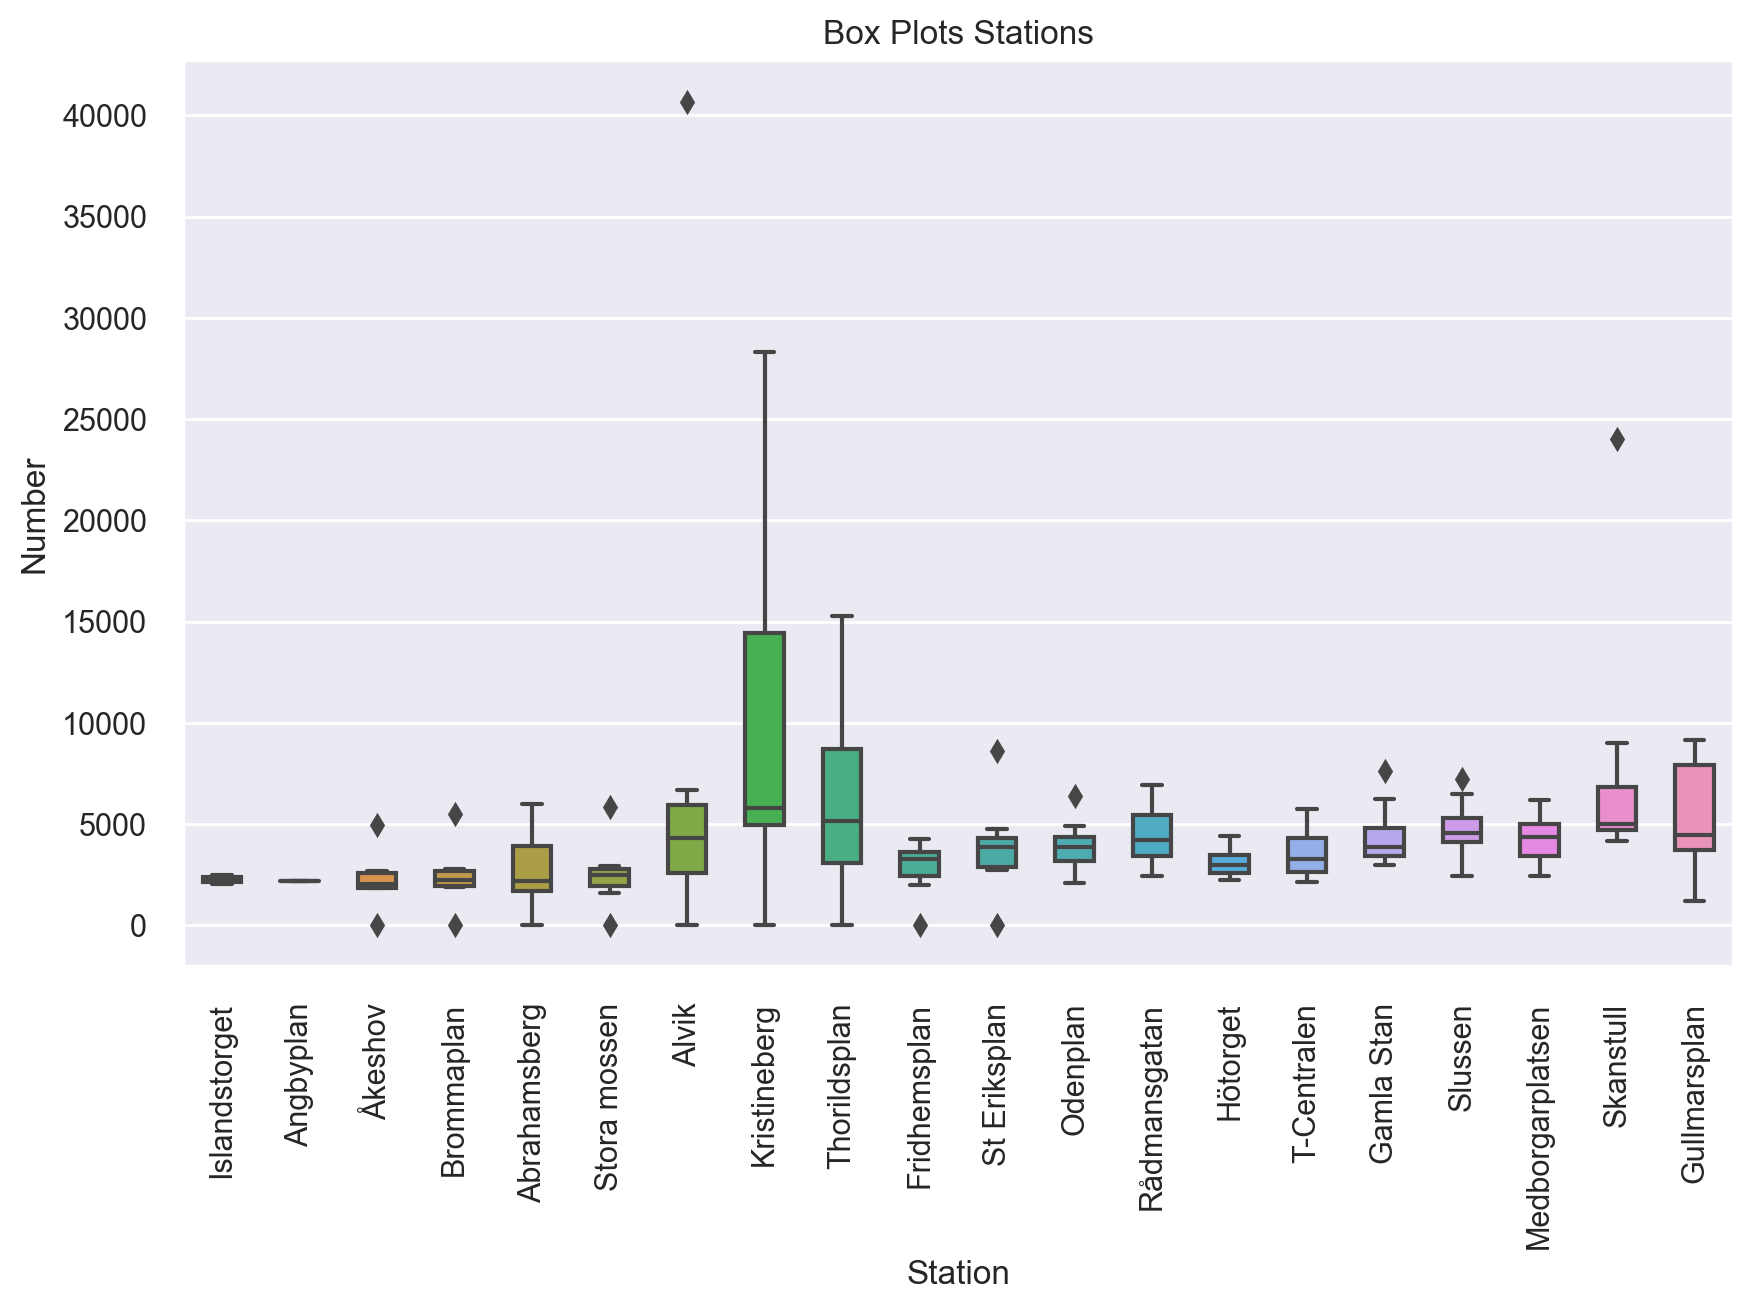

In [79]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Station', y=param, data=s_df, width=0.5, order=get_green_line())
plt.xticks(rotation=90)
plt.title('Box Plots Stations')
plt.savefig(f'{fig_folder}/box_plots({param}).pdf')

plt.show()

### Quantiles and outliers

In [80]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
station_quantiles = s_df.groupby('Station').agg(
    {param: 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

station_quantiles.to_csv(f'{fig_folder}/tables/station_quantiles({param}).csv')
station_quantiles[param].sort_values(by='outliers', ascending=False)

,Q1,Q2,Q3,IQR,lowerLimit,upperLimit,outliers,prcnt_outliers,count
Station,,,,,,,,,
Åkeshov,1870.25,2055.5,2583.50,713.25,800.375,3653.375,2.0,33.333333,6
Brommaplan,1942.50,2244.0,2686.00,743.50,827.250,3801.250,2.0,28.571429,7
Stora mossen,1941.00,2485.0,2801.00,860.00,651.000,4091.000,2.0,28.571429,7
St Eriksplan,2888.50,3861.0,4314.25,1425.75,749.875,6452.875,2.0,14.285714,14
Skanstull,4695.00,4986.0,6854.00,2159.00,1456.500,10092.500,1.0,9.090909,11
Fridhemsplan,2433.50,3265.5,3625.25,1191.75,645.875,5412.875,1.0,7.142857,14
Gamla Stan,3424.00,3887.0,4820.00,1396.00,1330.000,6914.000,1.0,9.090909,11
Slussen,4111.50,4567.5,5289.00,1177.50,2345.250,7055.250,1.0,8.333333,12
Alvik,2608.50,4321.5,5965.00,3356.50,-2426.250,10999.750,1.0,7.142857,14


**Comment**

Some stations have outliers. What happened during these sessions?

In [81]:
outlier_ids = print_outliers(s_df, station_quantiles, param)

=== OUTLIERS ===
Alvik:
	20211012-2 - Number = 40684.0

Brommaplan:
	20211006-3 - Number = 11.0
	20210929-2 - Number = 5503.0

Fridhemsplan:
	20211006-3 - Number = 11.0

Gamla Stan:
	20211008-1 - Number = 7616.0

Odenplan:
	20211001-3 - Number = 6397.0

Skanstull:
	20211005-1 - Number = 24044.0

Slussen:
	20211004-1 - Number = 7208.0

St Eriksplan:
	20211006-3 - Number = 11.0
	20211001-3 - Number = 8602.0

Stora mossen:
	20211006-3 - Number = 11.0
	20210929-2 - Number = 5828.0

Åkeshov:
	20211006-3 - Number = 11.0
	20210929-2 - Number = 4937.0

Unique outliers: ['20210929-2', '20211001-3', '20211004-1', '20211005-1', '20211006-3', '20211008-1', '20211012-2']


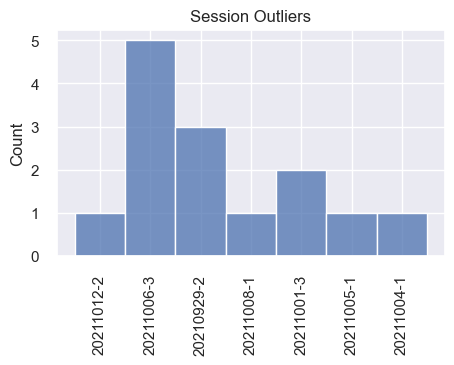

In [82]:
fig, ax = plt.subplots(figsize=[5, 3], dpi=100)

sns.histplot(outlier_ids)
plt.title('Session Outliers')
plt.xticks(rotation=90)
plt.show()

**Comment**

These sessions are worth examining and comparing with other sources. Especially session 20211004-2, as it contains 5 outliers within the same session!

## Rush and off hours

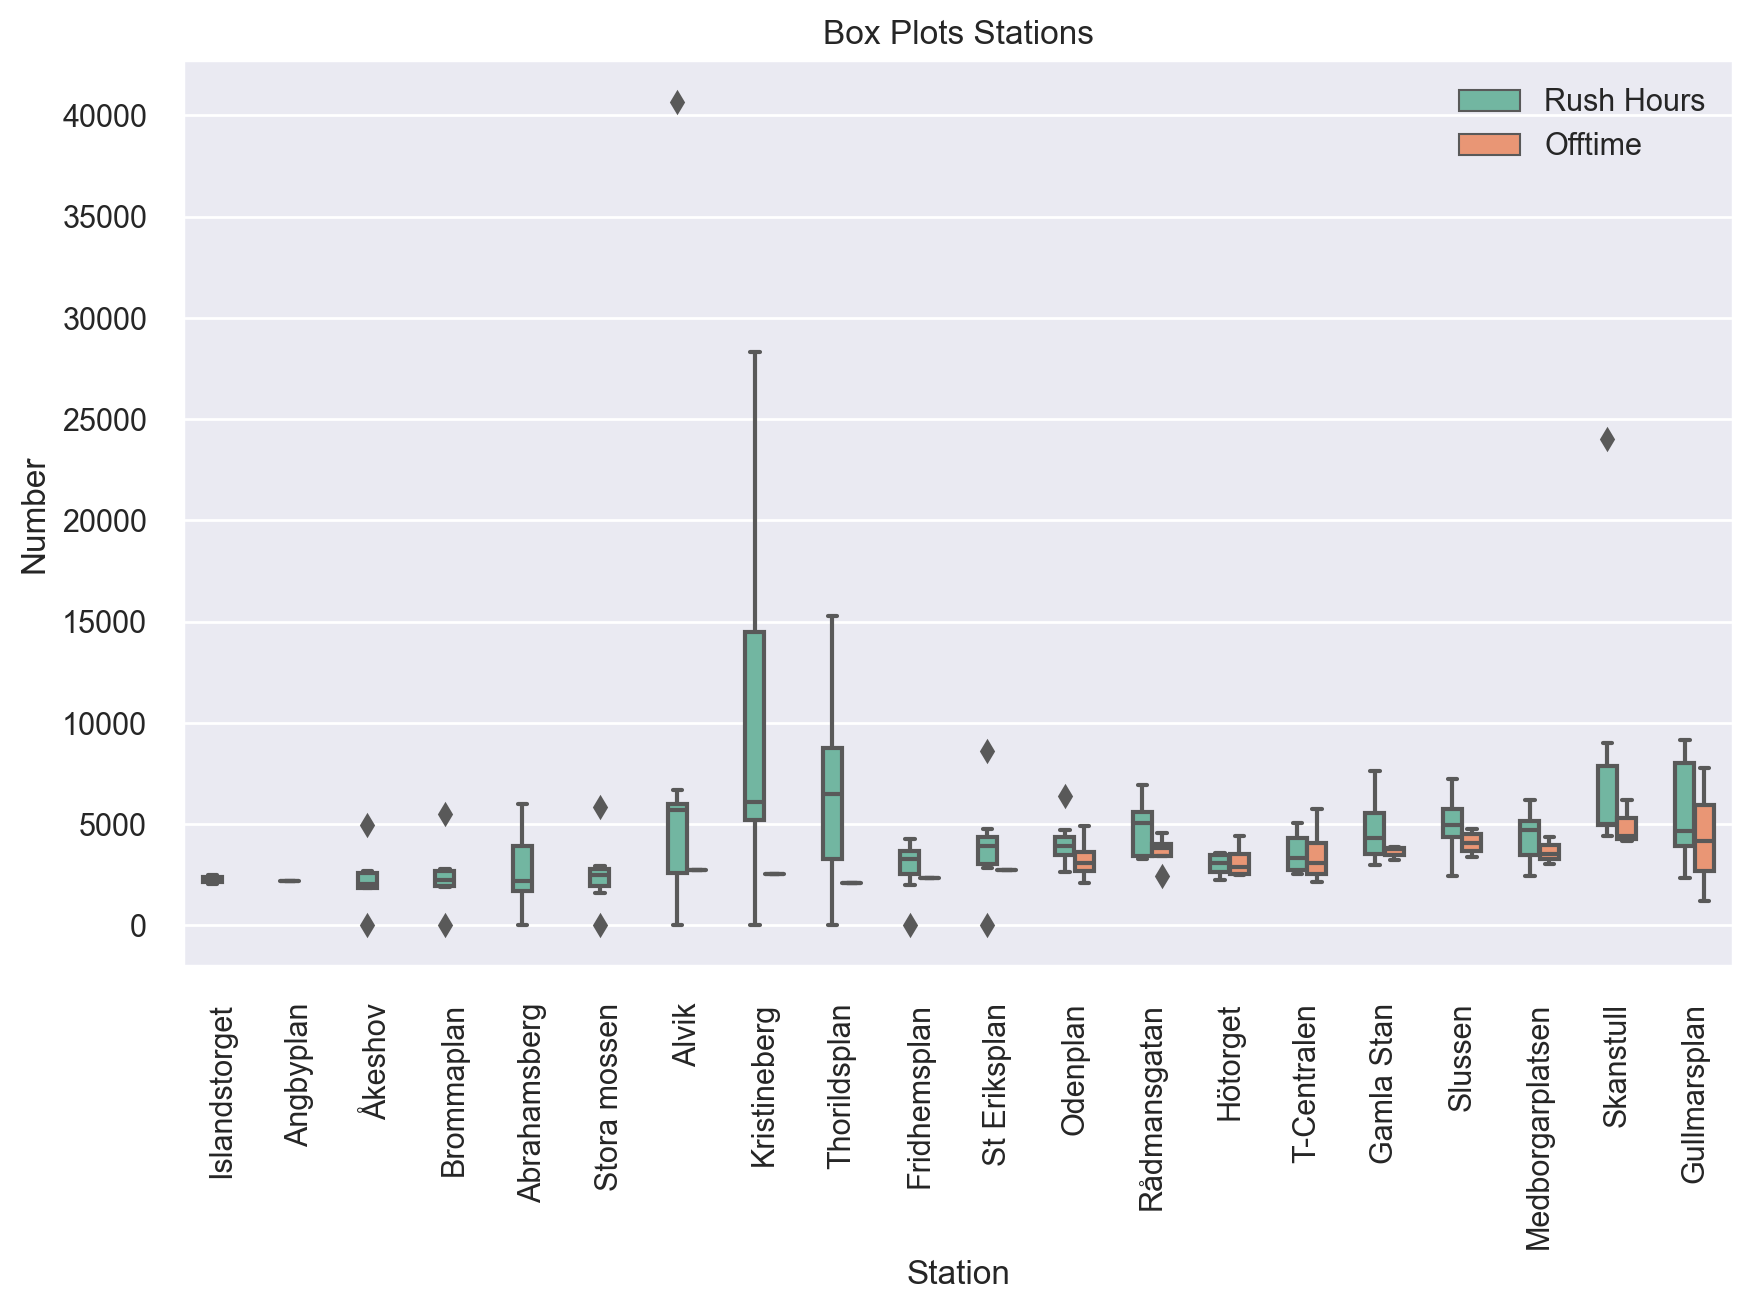

In [83]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

plot_df = s_df.copy()
plot_df['Period'] = plot_df['Period'].apply(lambda x: 'Rush Hours' if x in ['Evening rush', 'Morning rush'] else x)

sns.boxplot(
    x='Station', 
    y=param, 
    data=plot_df, 
    width=0.5, 
    order=get_green_line(), 
    hue='Period',
    palette="Set2"
)

plt.legend()
plt.xticks(rotation=90)
plt.title('Box Plots Stations')
plt.savefig(f'{fig_folder}/box_plots_rush_vs_offtime({param}).pdf')

plt.show()

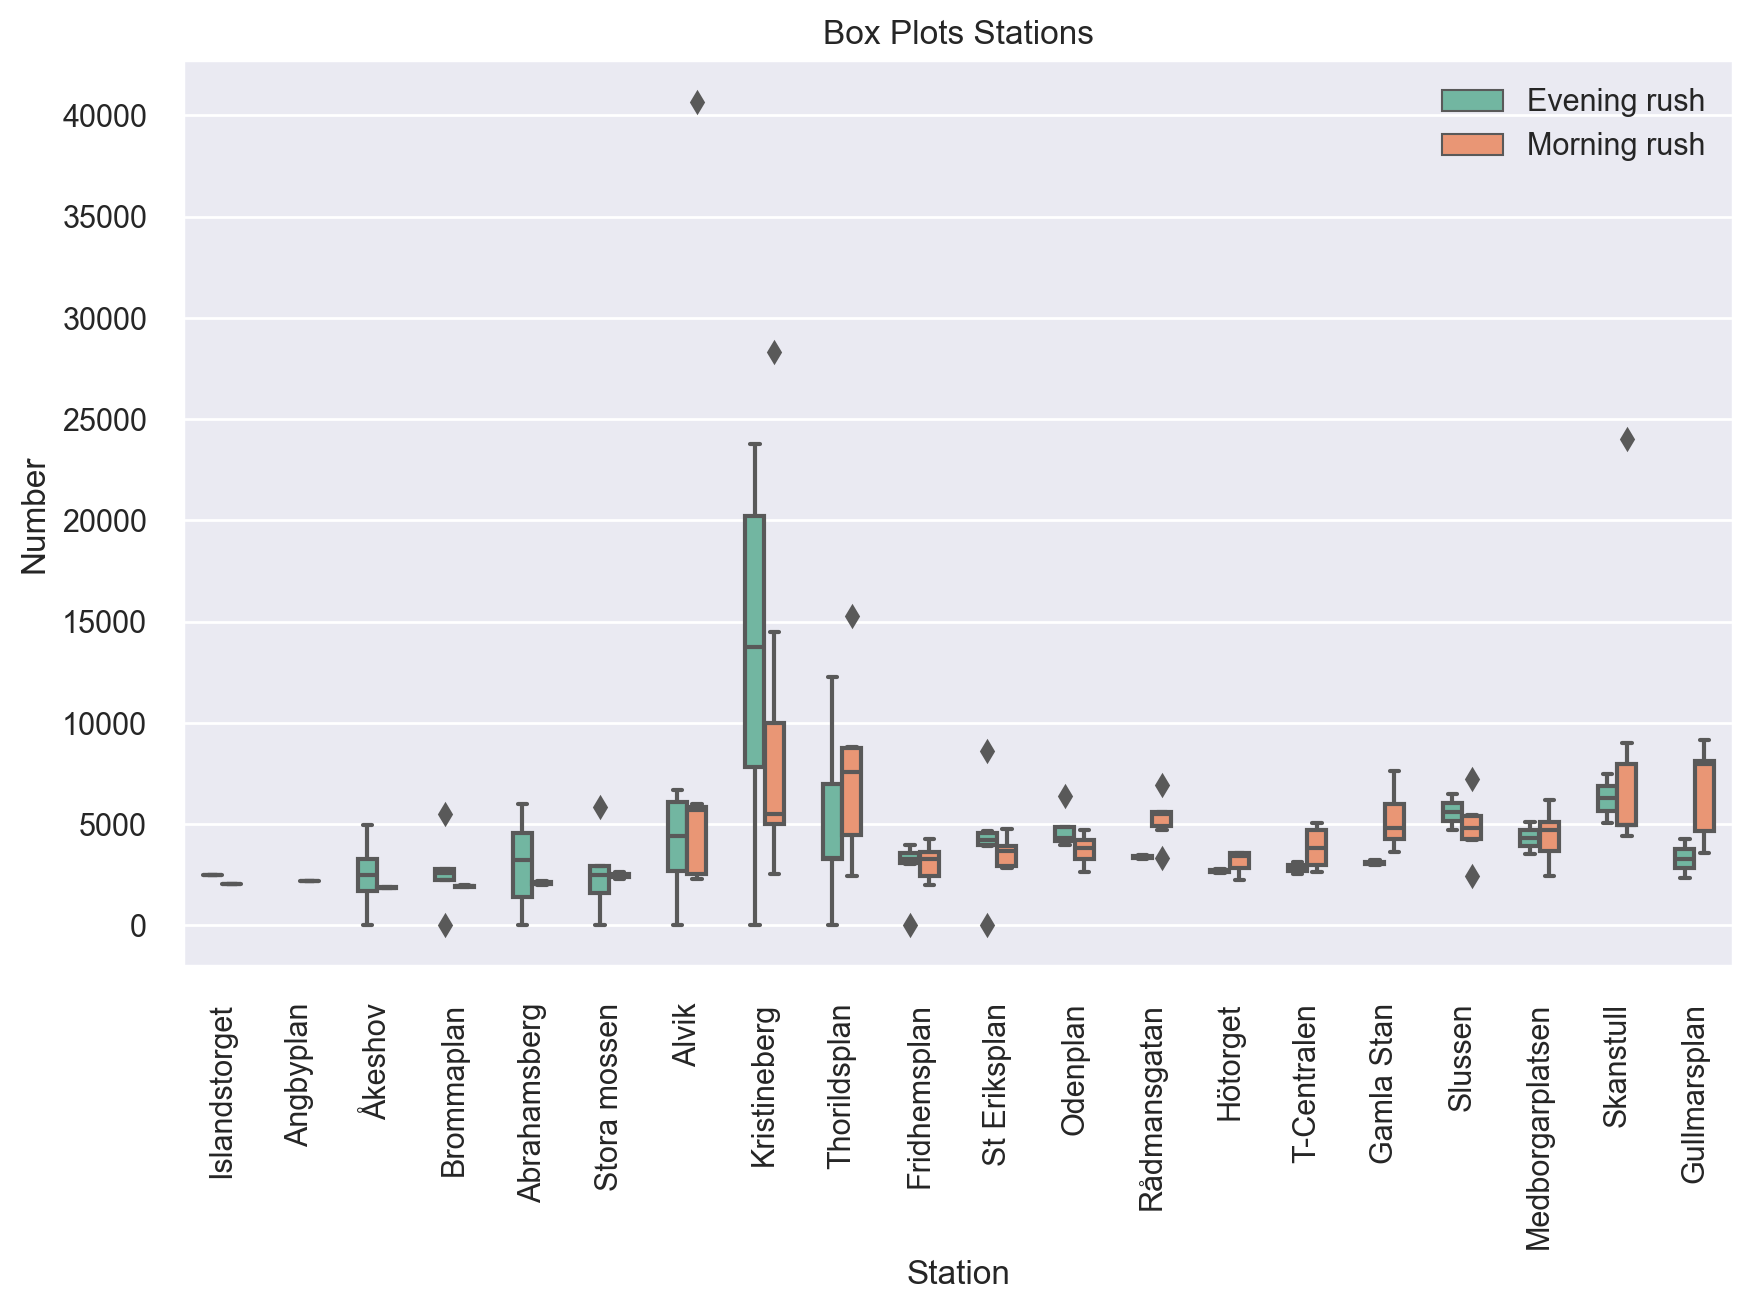

In [84]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

plot_df = s_df.loc[s_df['Period'] != 'Offtime']

sns.boxplot(
    x='Station', 
    y=param, 
    data=plot_df, 
    width=0.5, 
    order=get_green_line(), 
    hue='Period',
    palette="Set2"
)

plt.legend()
plt.xticks(rotation=90)
plt.title('Box Plots Stations')
plt.savefig(f'{fig_folder}/box_plots_morning_evening_rush({param}).pdf')

plt.show()

### Histograms

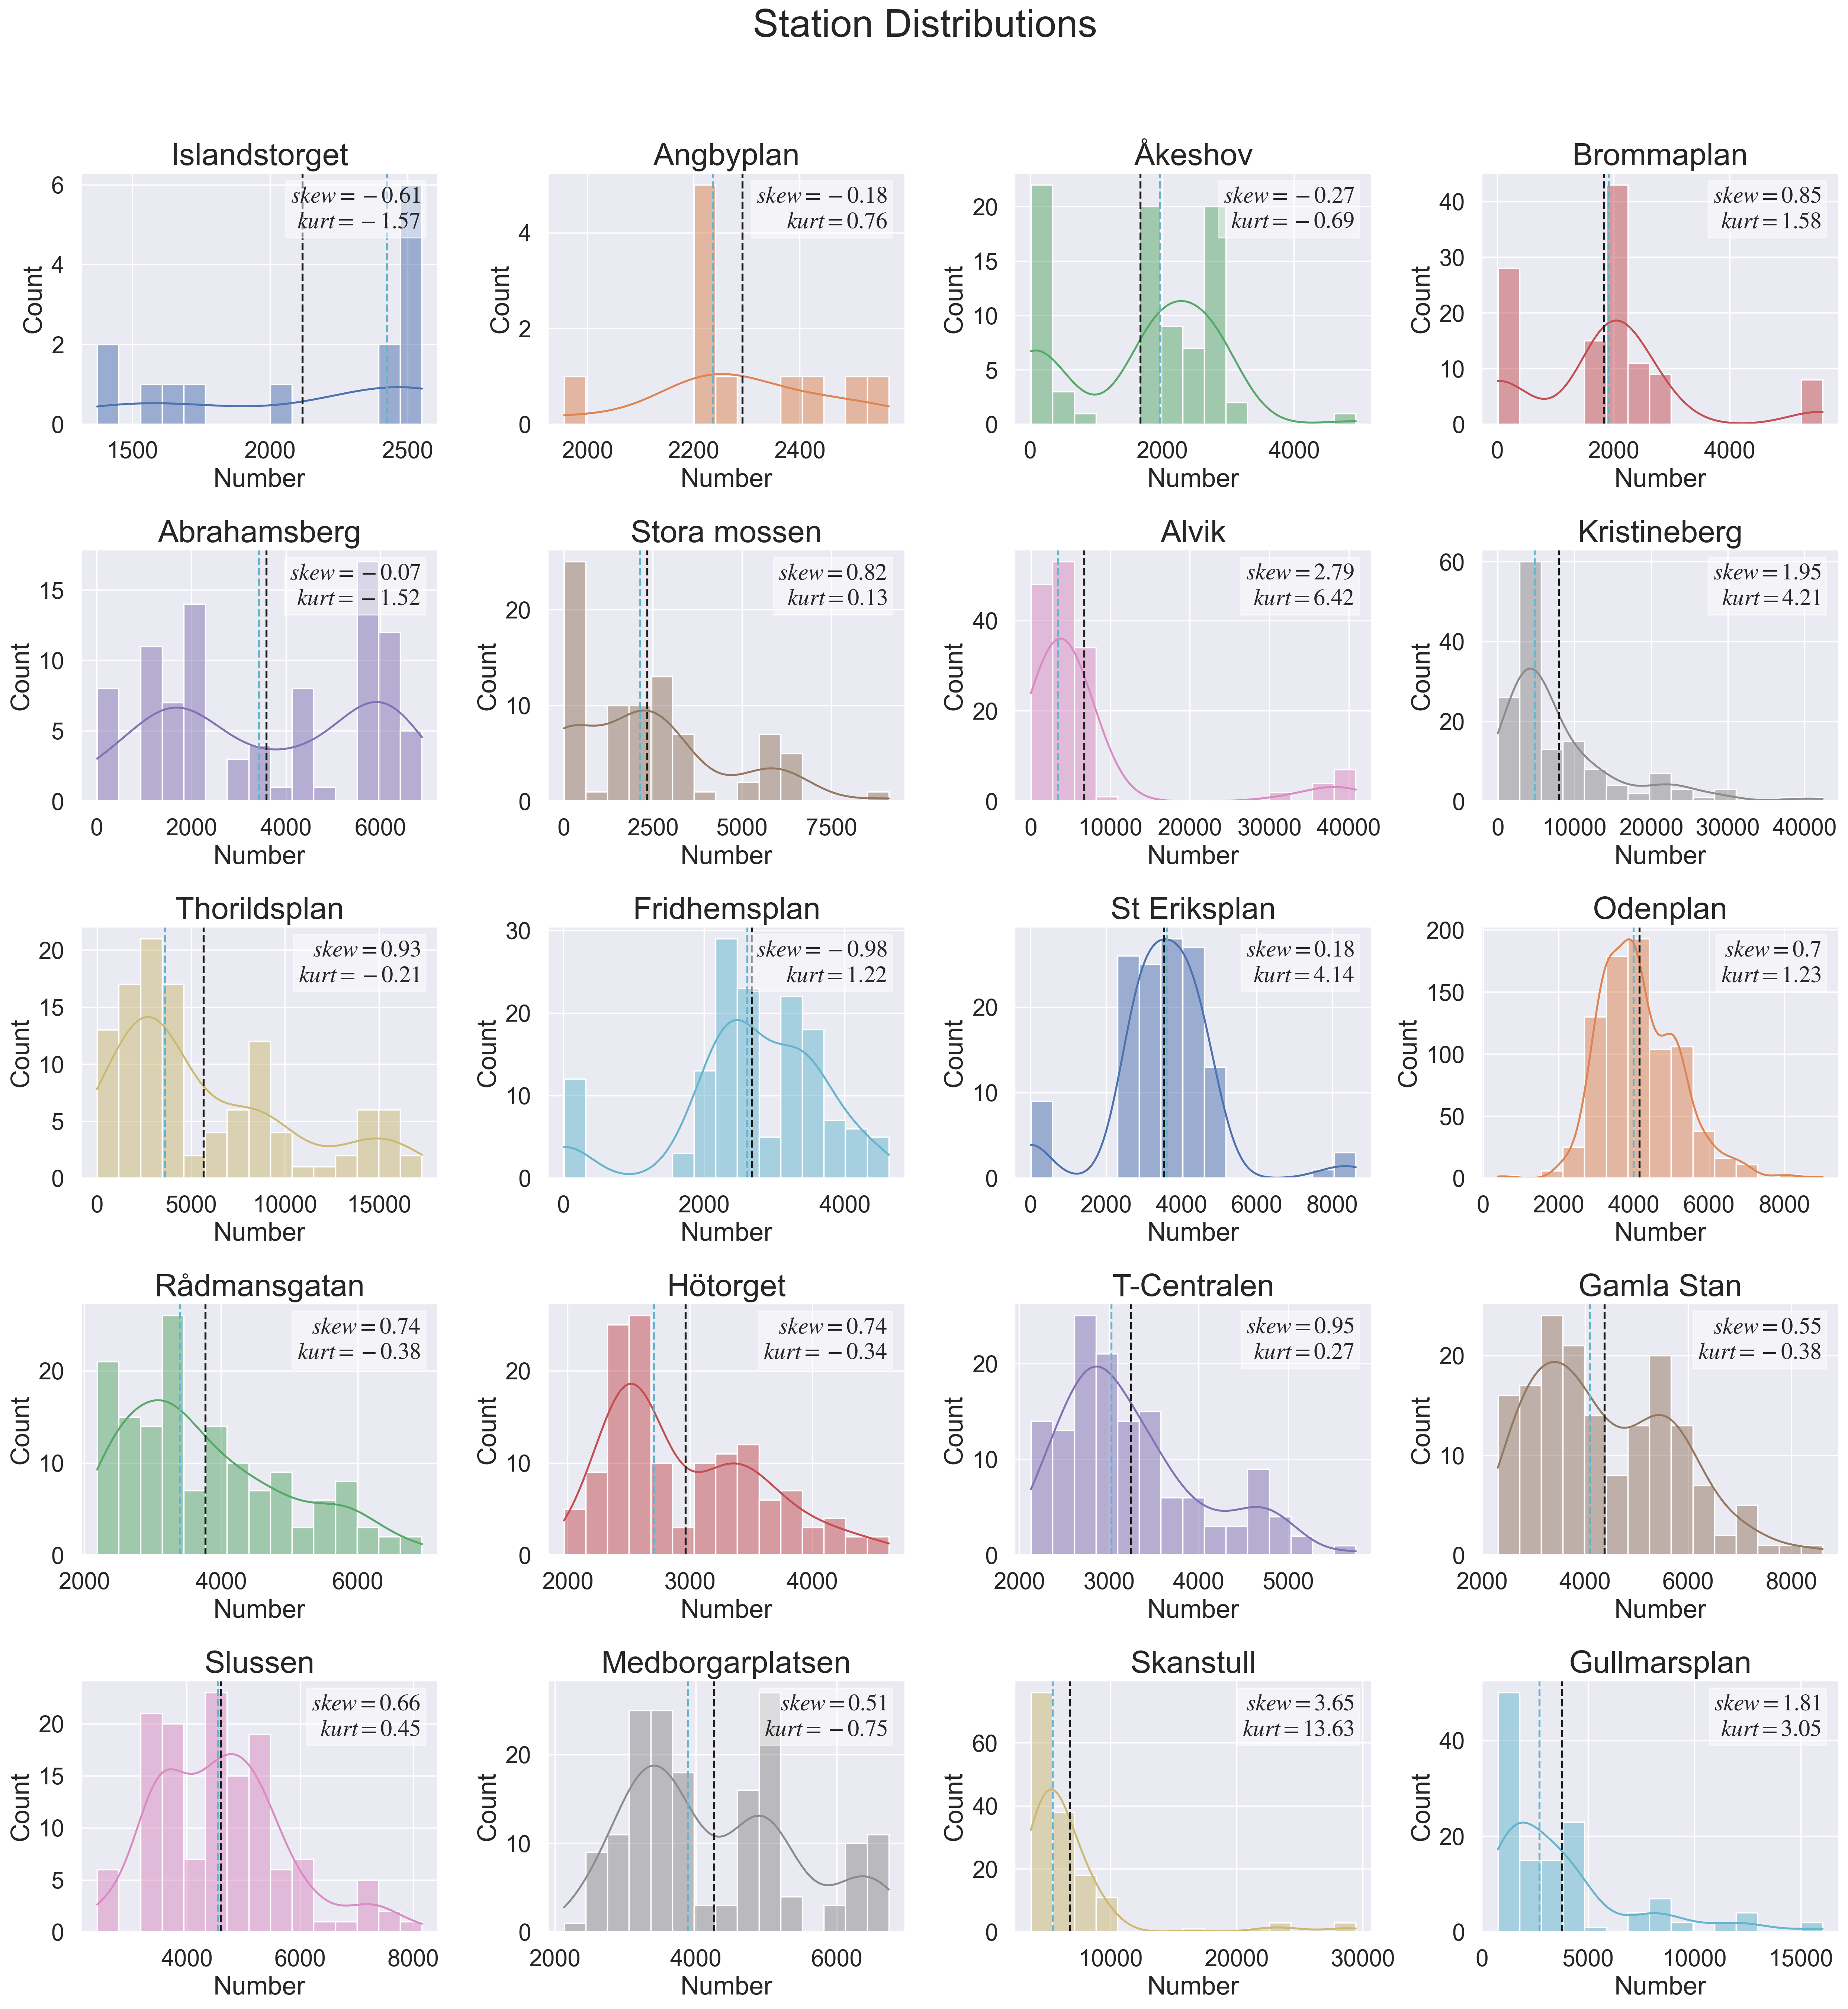

In [85]:
plot_distributions(
    df=r_df, 
    dist_col='Station', 
    title='Station Distributions', 
    fig_name=f'{fig_folder}/distributions({param}).pdf',
    param=param,
    with_textbox=True,
    column_count=4,
    bins=15
)

### Normal distribution

In [86]:
normal = r_df.groupby('Station').agg({param: [skew, kurtosis]})
normal[param].to_csv(f'{fig_folder}/tables/normal({param}).csv')

normal

Number           
                      skew   kurtosis
Station                              
Abrahamsberg     -0.071886  -1.520013
Alvik             2.794316   6.417396
Angbyplan        -0.179674   0.758497
Brommaplan        0.852202   1.581268
Fridhemsplan     -0.978973   1.221178
Gamla Stan        0.547618  -0.378318
Gullmarsplan      1.813772   3.054801
Hötorget          0.740249  -0.335916
Islandstorget    -0.613254  -1.570417
Kristineberg      1.947897   4.209743
Medborgarplatsen  0.514621  -0.748796
Odenplan          0.702476   1.228640
Rådmansgatan      0.744329  -0.376360
Skanstull         3.648252  13.627220
Slussen           0.658348   0.451434
St Eriksplan      0.180650   4.140160
Stora mossen      0.817191   0.128327
T-Centralen       0.954893   0.271147
Thorildsplan      0.930161  -0.213178
Åkeshov          -0.273242  -0.687747

#### QQ Plots

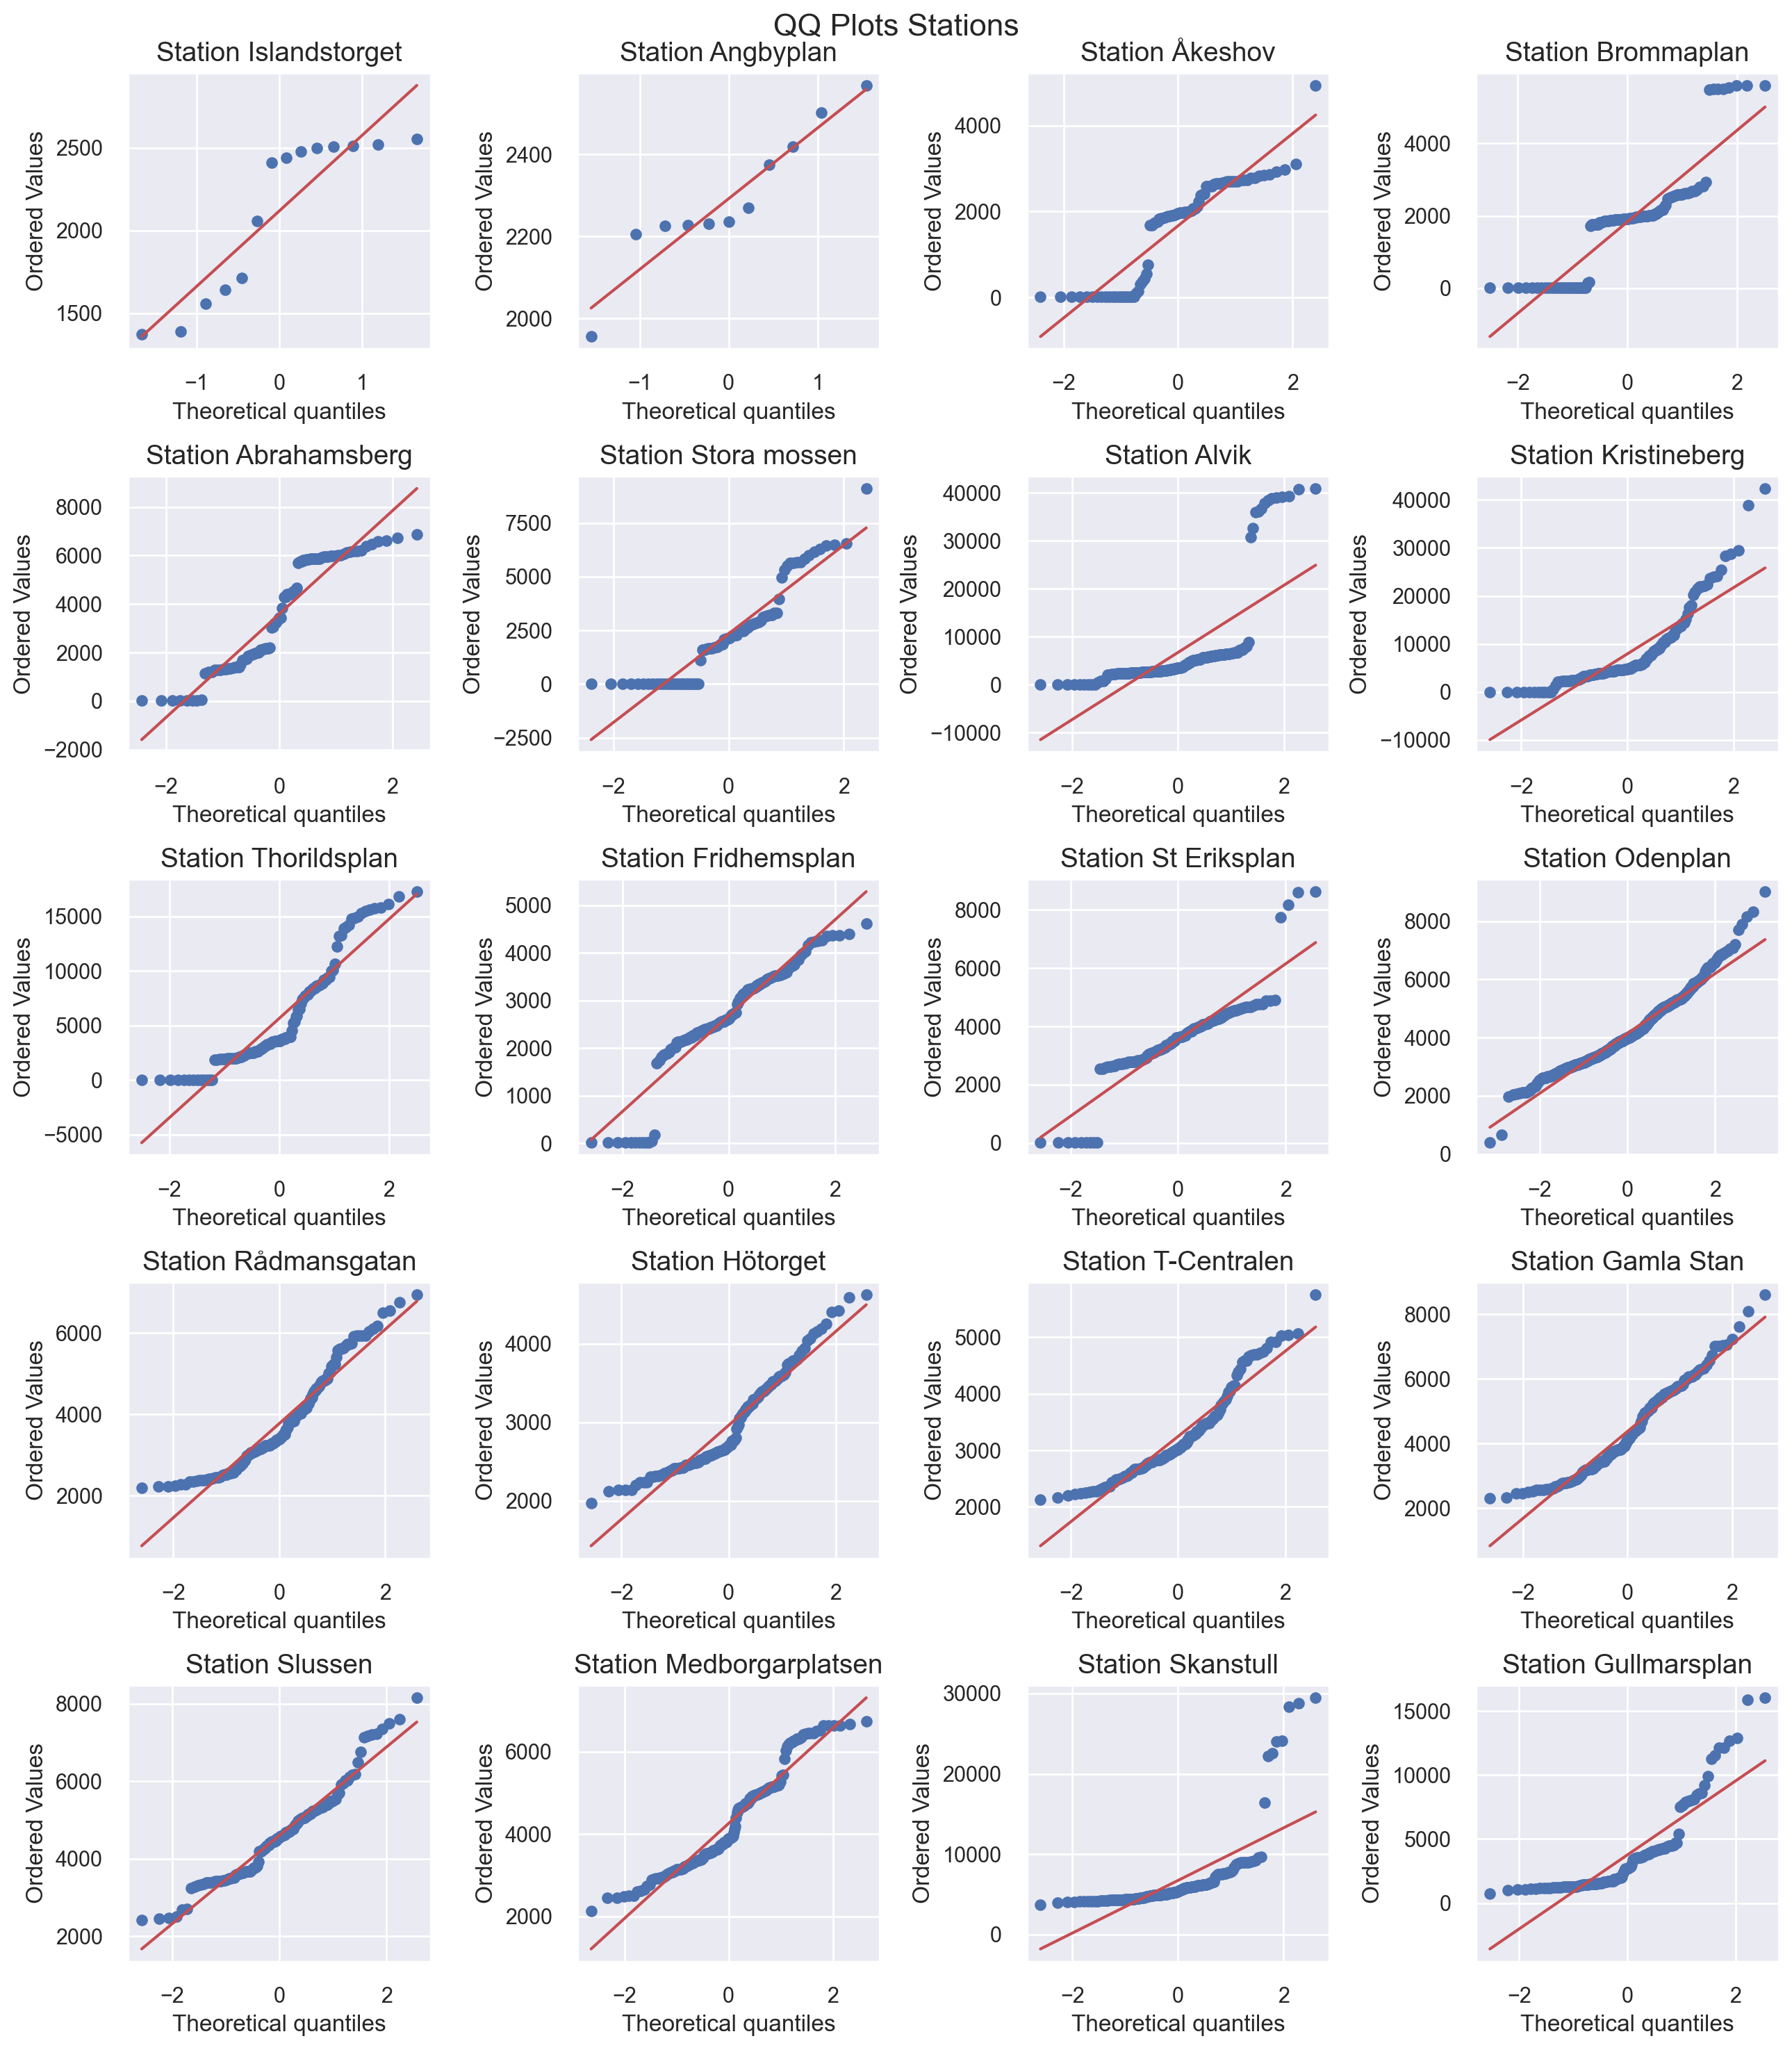

In [87]:
plot_QQ_plots(
    r_df, 
    title='QQ Plots Stations', 
    param=param, 
    fig_name=f'{fig_folder}/QQPlots({param}).pdf',
    col_count=4,
    row_count=5,
    label='Station',
    size=(13, 15)
)

### Sensor diffs

How much do the sensor means per session per station differ? Compute standard deviation per session per station.

In [88]:
station_diffs = {}

for session_id, grp in r_df.groupby('Session Id'):
    for station, station_grp in grp.groupby('Station'):
        if station not in station_diffs:
            station_diffs[station] = []
            
        # Compute std
        station_diffs[station].append(sample_std(station_grp[param].values))
            
# Convert into one long array and make a histogram
station_diffs

mean_station_diffs = {s: np.nanmean(v) for s, v in station_diffs.items()}
mean_station_diffs

station_diffs_df = pd.DataFrame(list(mean_station_diffs.items()), columns=['station', 'mean sensor std'])
station_diffs_df['order'] = [get_green_line().index(station) for station in mean_station_diffs.keys()]

print(f'Total mean sensor diff: {station_diffs_df["mean sensor std"].mean()}')

station_diffs_df.to_csv(f'{fig_folder}/tables/sensors_diffs_per_station({param}).csv')

station_diffs_df.sort_values(by=['mean sensor std'], ascending=False)

Total mean sensor diff: 553.2166646278768


/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,station,mean sensor std,order
14,Kristineberg,2872.649146,7
6,Skanstull,1204.450968,18
17,Thorildsplan,799.990715,8
1,Gullmarsplan,784.821566,19
16,Stora mossen,761.297873,5
10,Alvik,678.141770,6
13,Islandstorget,492.660543,0
0,Gamla Stan,392.997680,15
4,Odenplan,386.711017,11
9,Abrahamsberg,382.122286,4


### How much do every single sensor differ per station?

In [89]:
diffs = {}

for station, grp in r_df.groupby('Station'):
    diffs[station] = {}
    for sensor, sensor_grp in grp.groupby('Sensor'):
        diffs[station][sensor] = sample_std(sensor_grp[param].values)

diffs_df = pd.concat([pd.DataFrame(diffs[s].values(), index=diffs[s].keys(), columns=[s]).T for s in r_df['Station'].unique()])

diffs_df.loc['Avg'] = diffs_df.mean()

diffs_df.to_csv(f'{fig_folder}/tables/sensor_diff_per_station({param}).csv')

diffs_df

,DiSC
Islandstorget,473.631586
Angbyplan,166.947896
Åkeshov,1138.538976
Brommaplan,1382.006792
Abrahamsberg,2216.190022
Stora mossen,2153.827674
Alvik,9747.760321
Kristineberg,7728.919354
Thorildsplan,4780.112198
Fridhemsplan,1049.208523


# Focus on Kristineberg

In [90]:
focus_s_df = s_df.loc[s_df.Station == 'Kristineberg'].sort_values(by=['Timestamp'])
focus_r_df = r_df.loc[r_df.Station == 'Kristineberg'].sort_values(by=['Sensor'])

### Box plots sensors

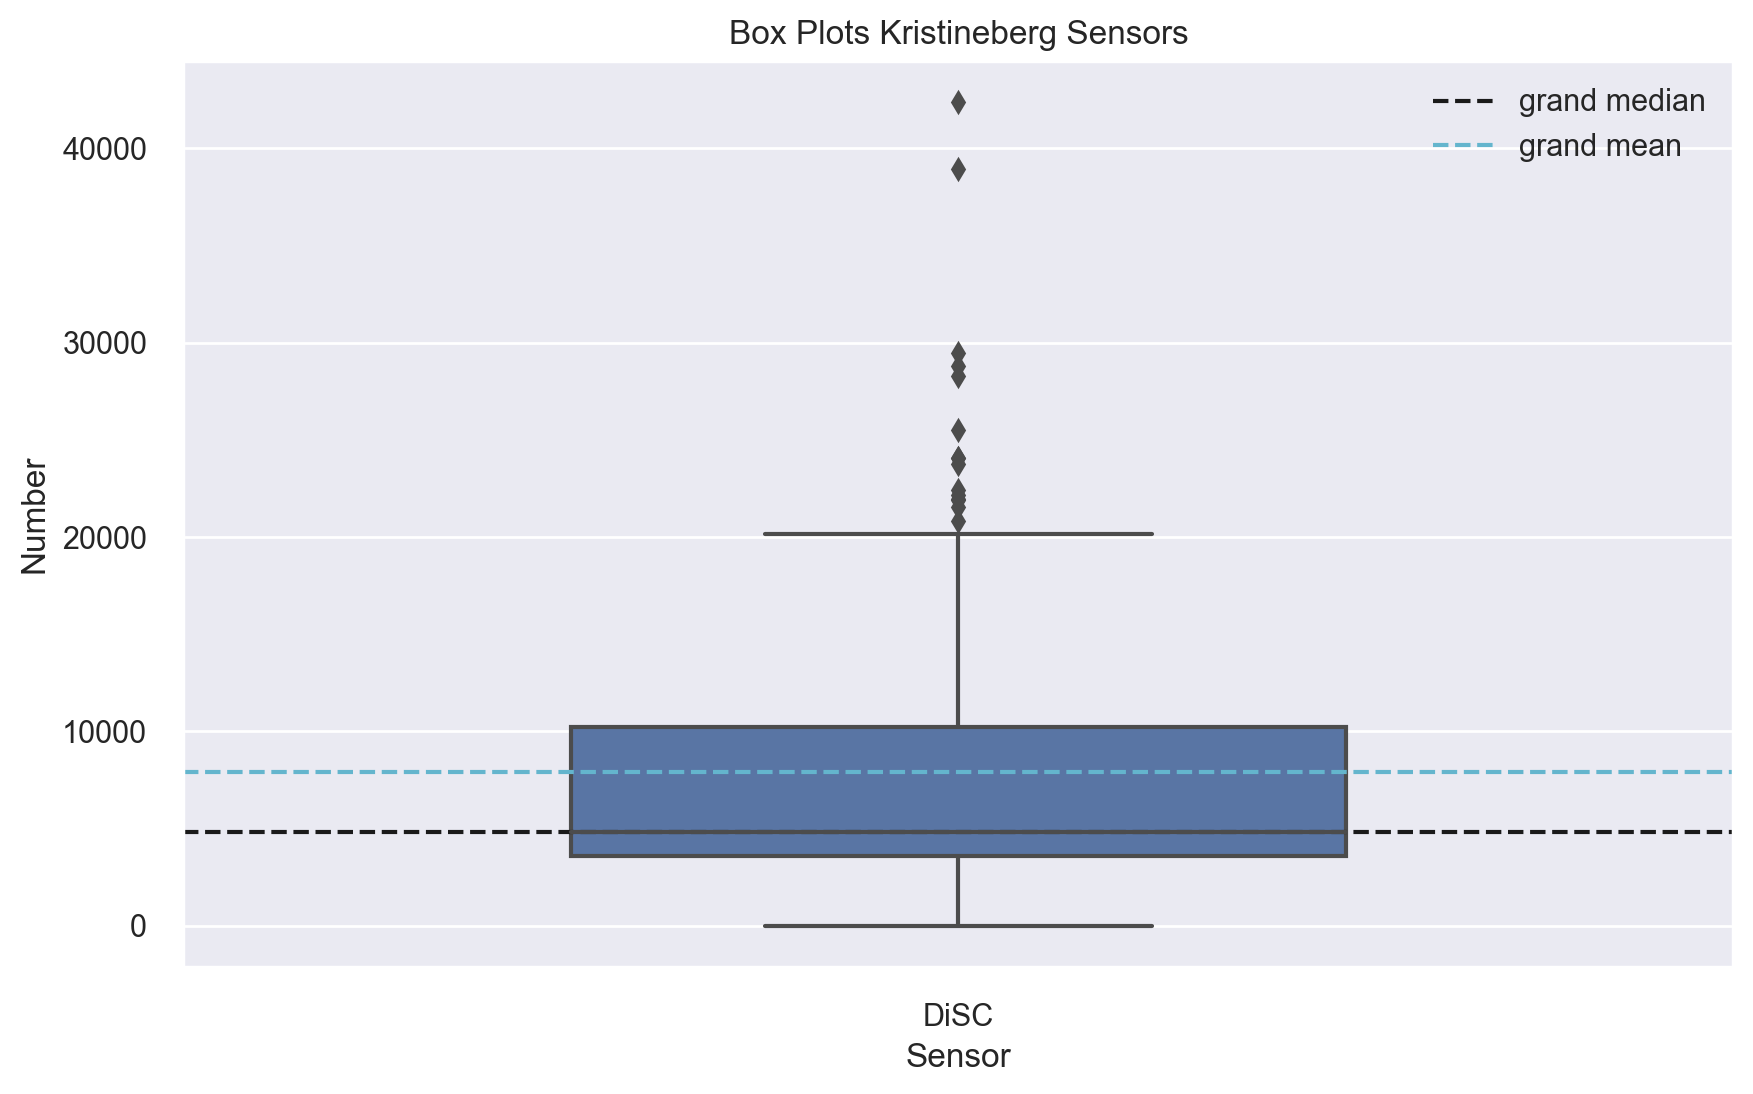

In [91]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Sensor', y=param, data=focus_r_df, width=0.5)

plt.axhline(focus_r_df[param].median(), c='k', linestyle='--', label='grand median')
plt.axhline(focus_r_df[param].mean(), c='c', linestyle='--', label='grand mean')

plt.legend()
plt.title('Box Plots Kristineberg Sensors')
plt.savefig(f'{fig_folder}/Kristineberg_box_plot_sensor({param}).pdf')
plt.show()

In [92]:
station_diffs['Kristineberg']

[1413.1200703879813,
 2469.4084480566057,
 724.7869903072774,
 5168.464458873386,
 1438.2590266630616,
 4341.0147579306185,
 5442.550677557148,
 2659.3792884806785,
 138.27538947091537,
 2370.55782464803,
 12354.218234181304,
 272.9253838533806,
 1223.1230518635482,
 201.00444202625403]

In [93]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
quantiles = focus_r_df.groupby('Sensor').agg(
    {param: 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

# Display stats
quantiles

Number                                                         \
             Q1    Q2       Q3      IQR lowerLimit upperLimit outliers   
Sensor                                                                   
DiSC    3573.25  4810  10244.5  6671.25  -6433.625  20251.375       15   

                             
       prcnt_outliers count  
Sensor                       
DiSC        10.416667   144

### Box plot sessions

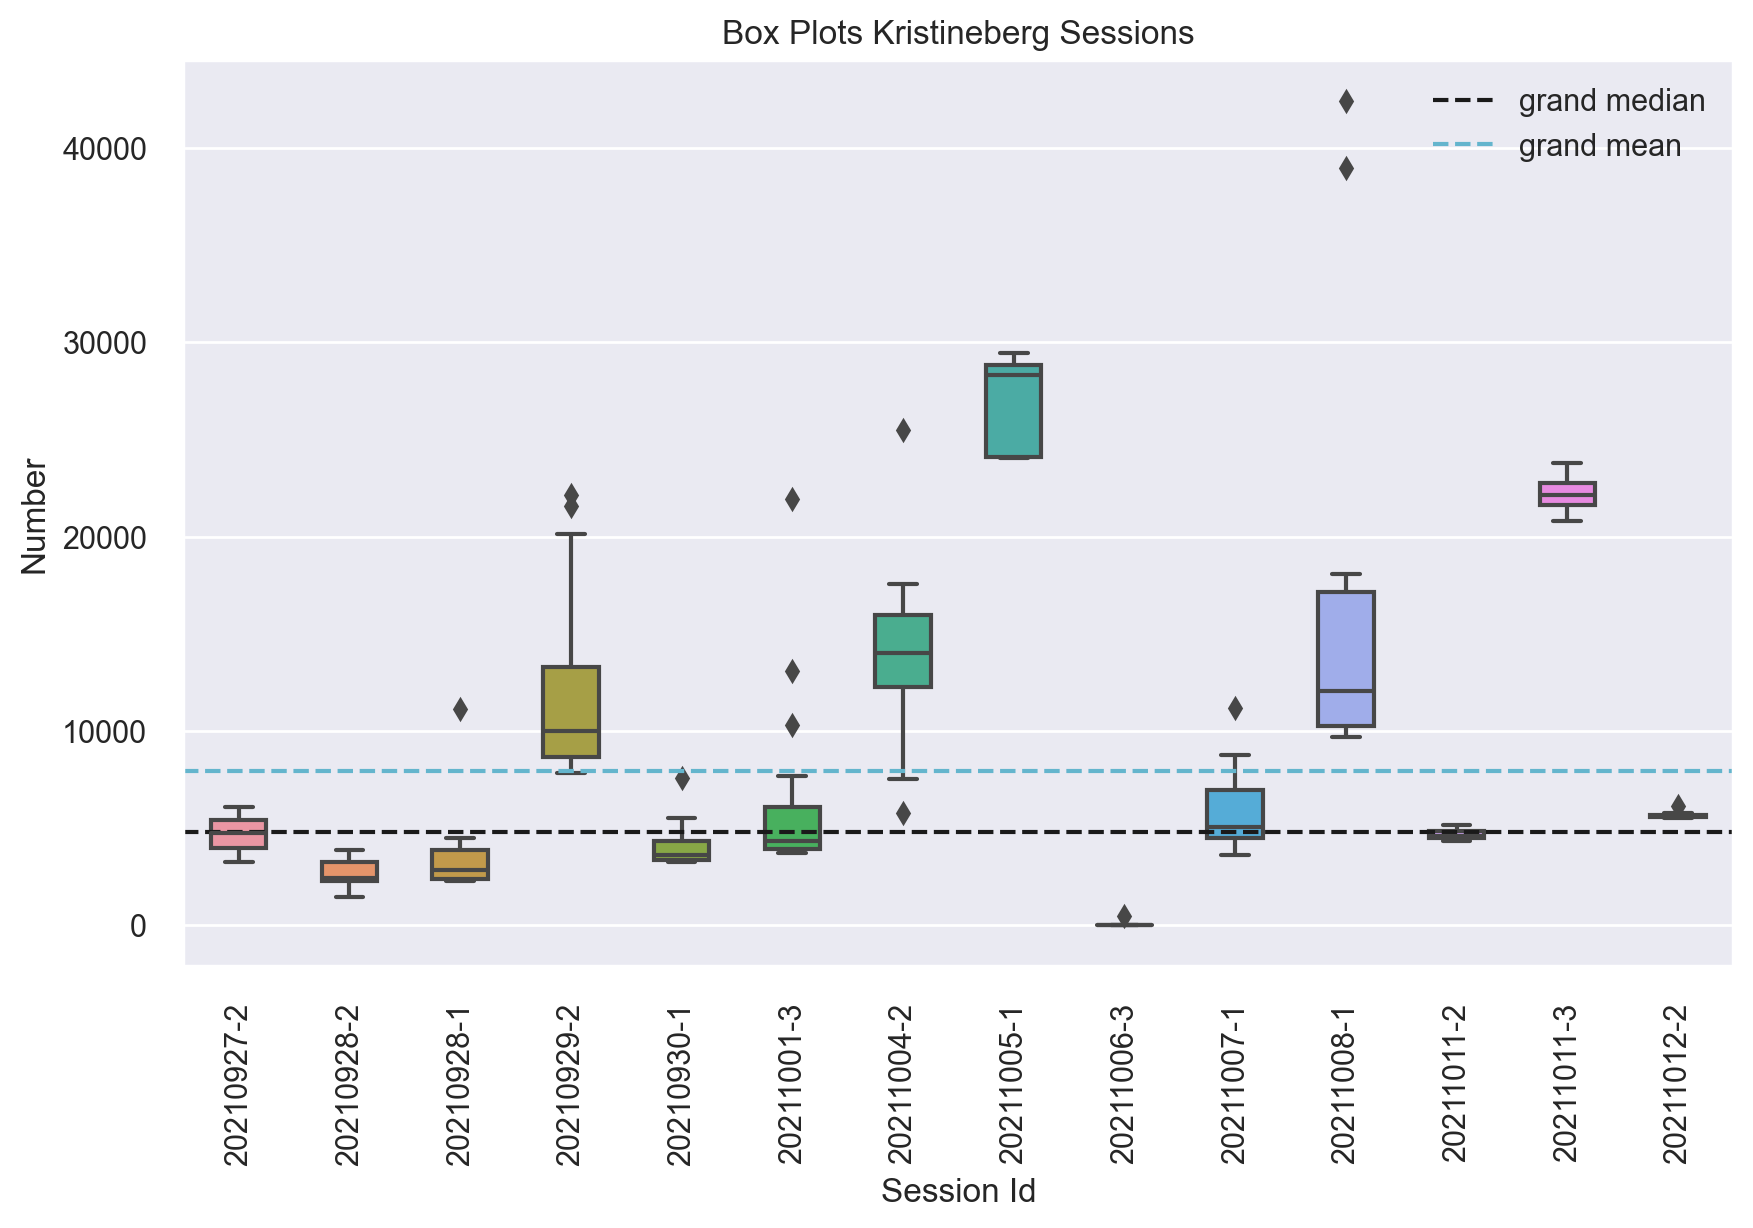

In [94]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Session Id', y=param, data=focus_r_df.sort_values(by=['Timestamp']), width=0.5)

plt.axhline(focus_r_df[param].median(), c='k', linestyle='--', label='grand median')
plt.axhline(focus_r_df[param].mean(), c='c', linestyle='--', label='grand mean')

plt.xticks(rotation=90)
plt.legend()
plt.title('Box Plots Kristineberg Sessions')
plt.savefig(f'{fig_folder}/Kristineberg_box_plot_sessions({param}).pdf')
plt.show()

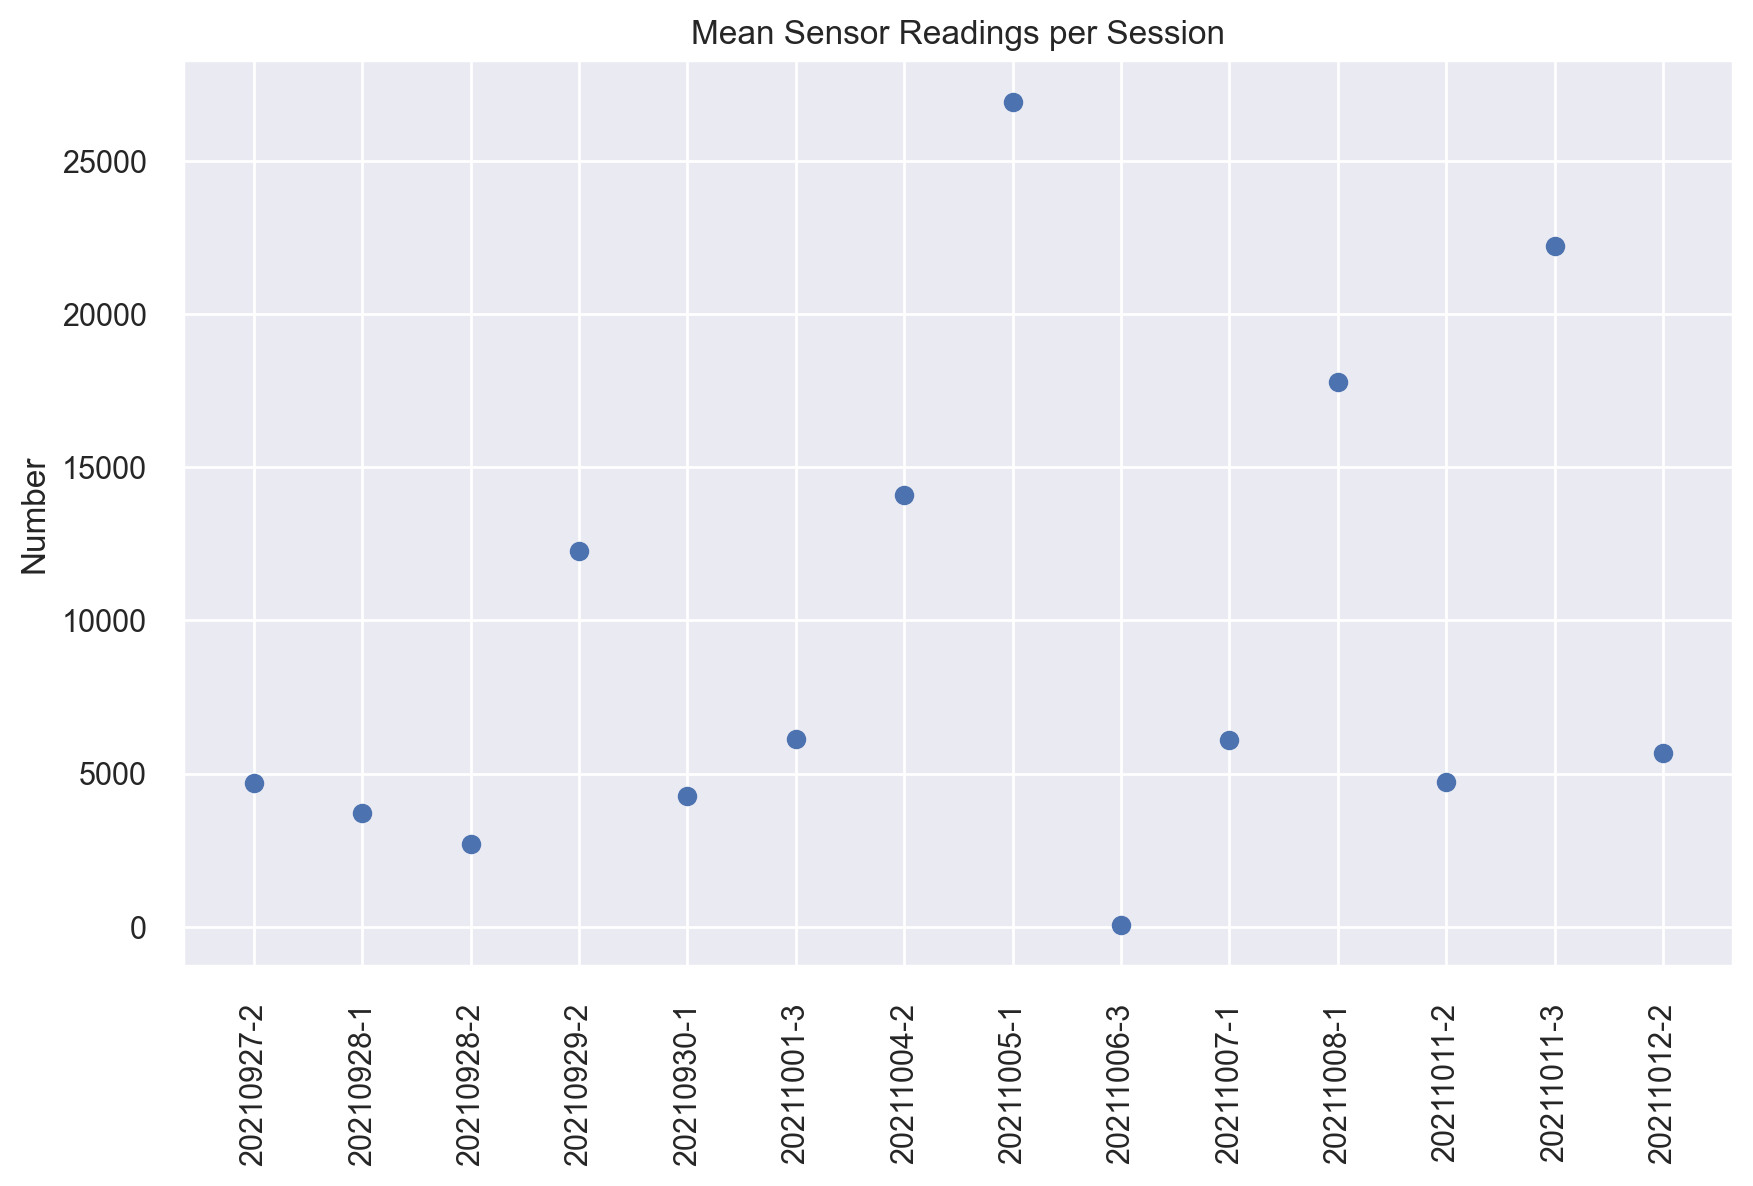

In [95]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

session_sensors = {}
for sensor, grp in focus_r_df.groupby('Sensor'):
    if sensor not in session_sensors:
        session_sensors[sensor] = {}
        
    for session_id, session_grp in grp.groupby('Session Id'):
        session_sensors[sensor][session_id] = session_grp[param].mean()
        
for sensor, data in session_sensors.items():
    ax.scatter(data.keys(), data.values(), label=sensor)
    
plt.xticks(rotation=90)
#plt.legend()
plt.title('Mean Sensor Readings per Session')
plt.savefig(f'{fig_folder}/Kristineberg_mean_sensor_reading_per_session({param}).pdf')
plt.ylabel(param)

plt.show()

### Distribution

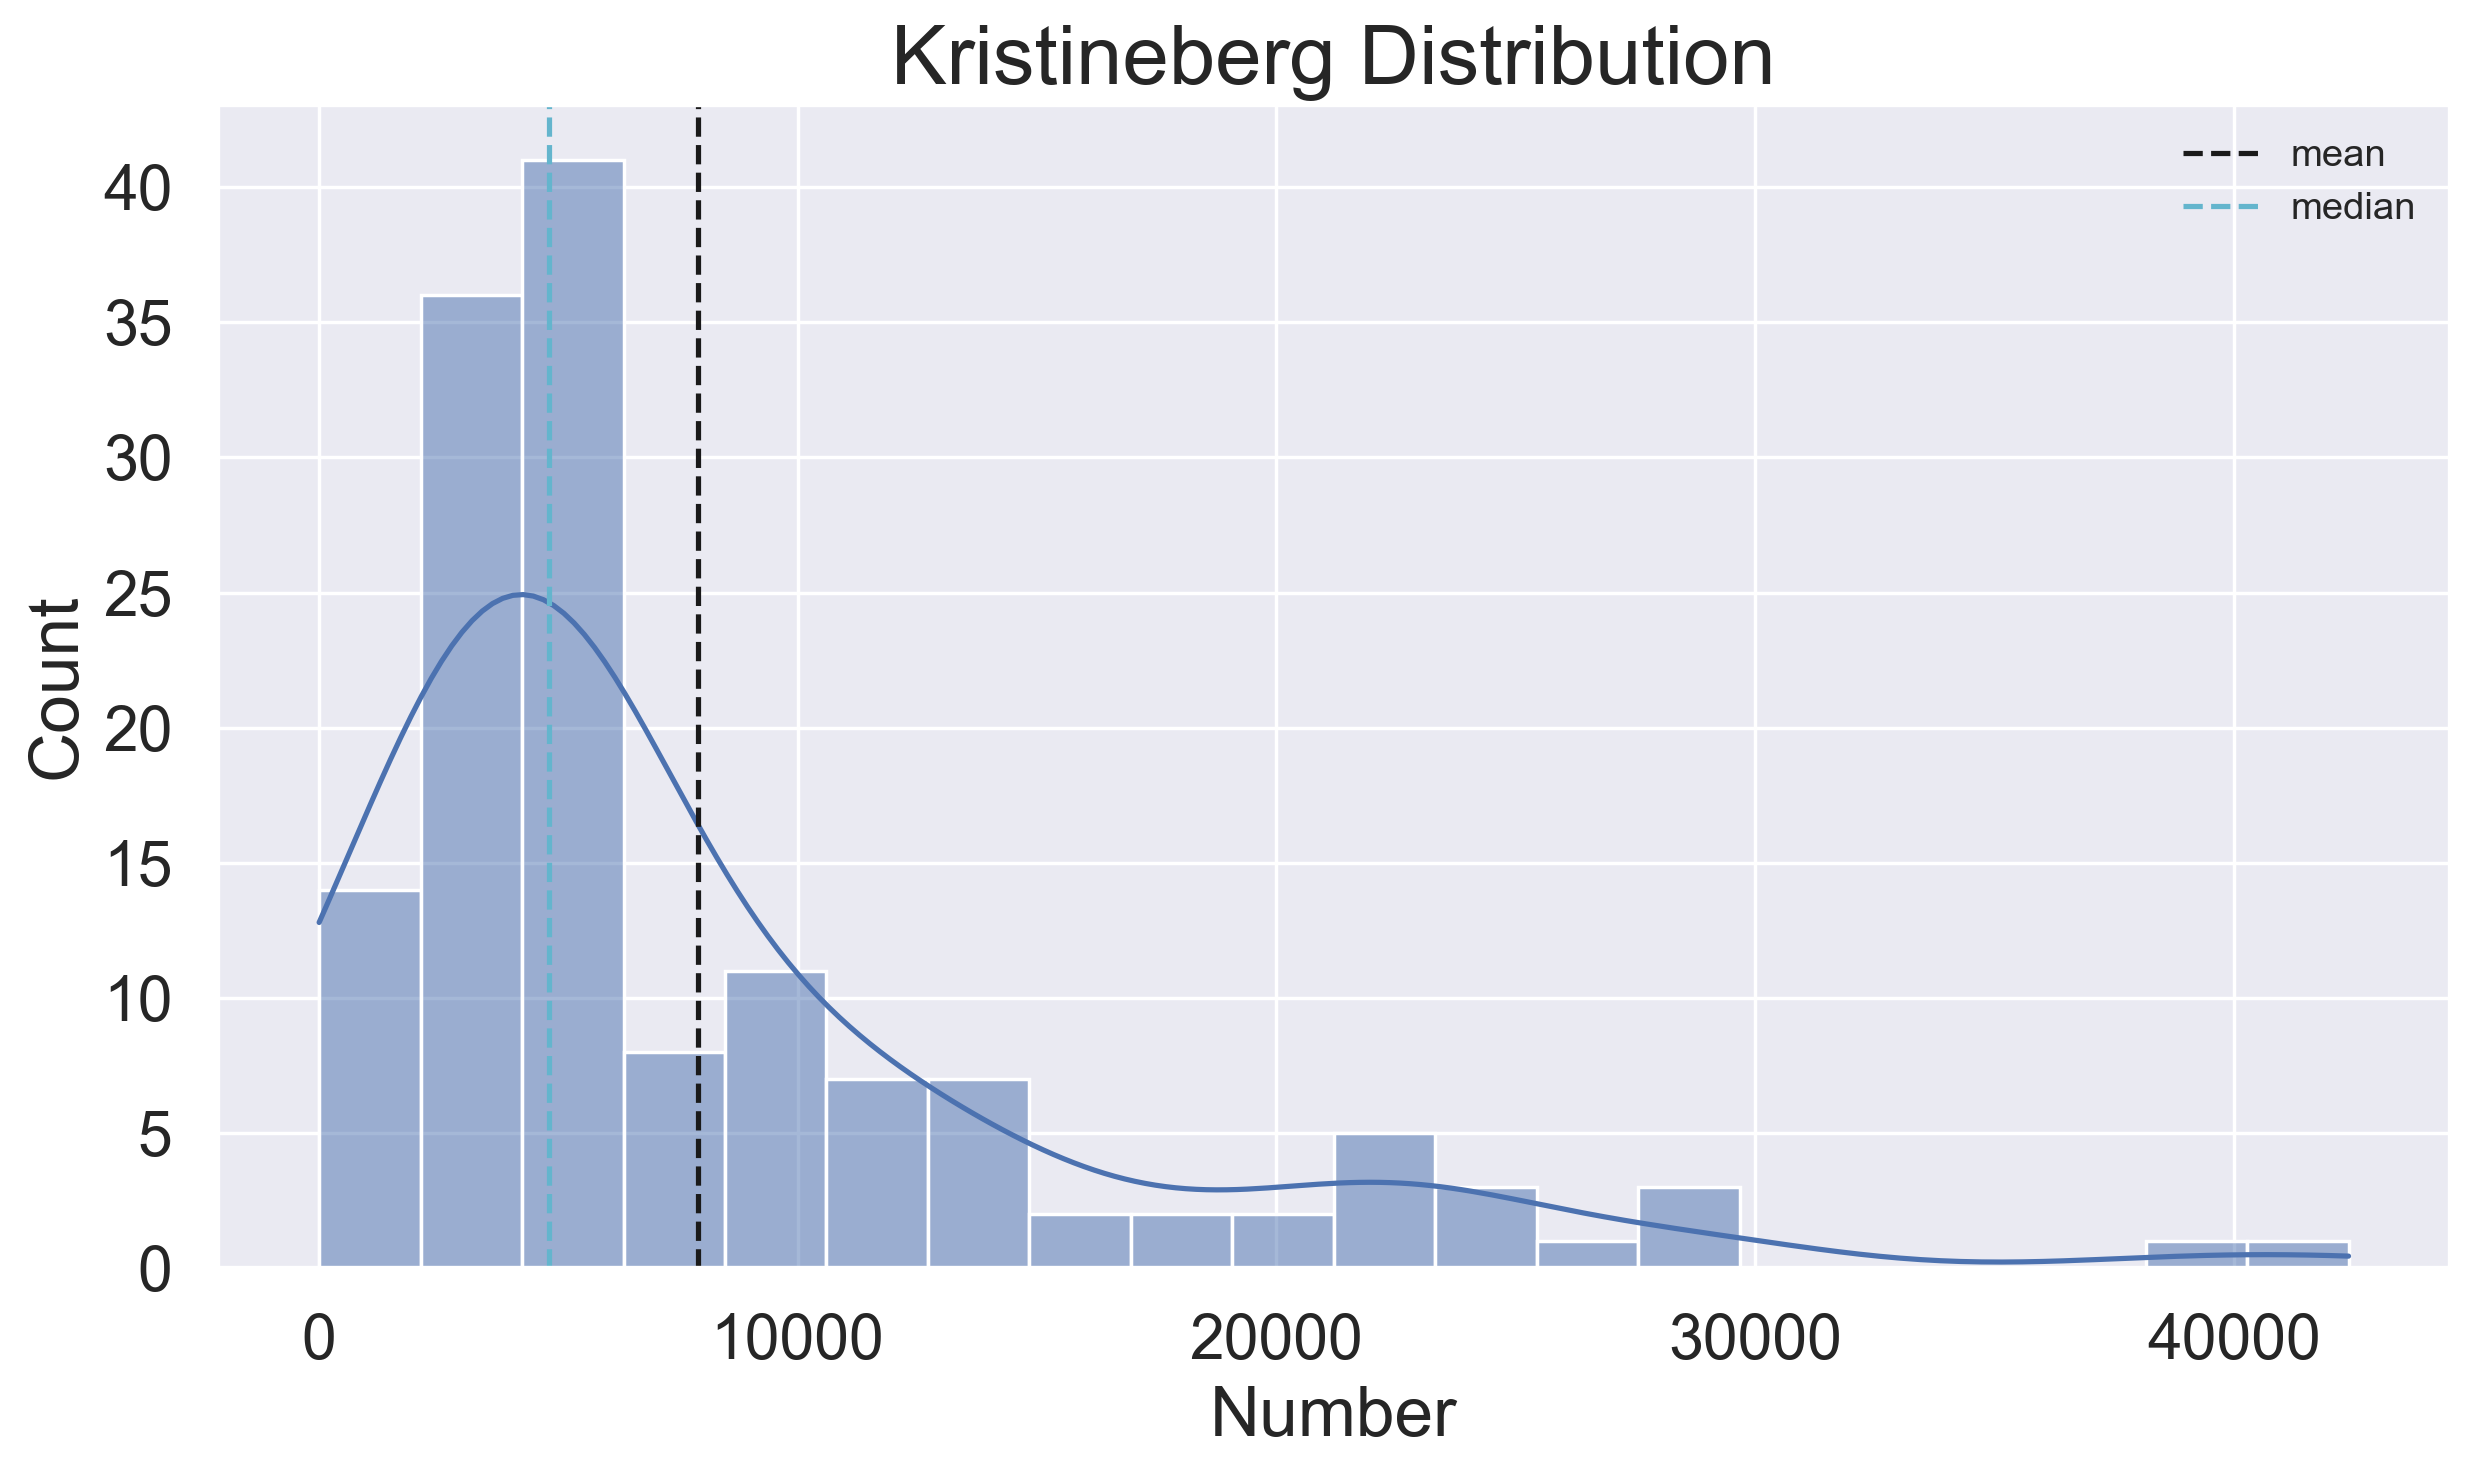

In [97]:
fig, ax = plt.subplots(dpi=250, figsize=[10, 6])

mean = focus_r_df[param].mean()
median = focus_r_df[param].median()
std = sample_std(focus_r_df[param].values)
s_skew = stats.skew(focus_r_df[param], bias=False)
s_kurt = stats.kurtosis(focus_r_df[param], bias=False)

sns.histplot(focus_r_df, x=param, kde=True, bins=20)

ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)

ax.set_xlabel(param, fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.set_title(f"Kristineberg Distribution", fontsize=24)

ax.axvline(mean, c="k", linestyle="--", label="mean")
ax.axvline(median, c="c", linestyle="--", label="median")
ax.legend()
plt.tight_layout()

plt.savefig(f'{fig_folder}/KristinebergDistribution({param}).pdf')

plt.show()

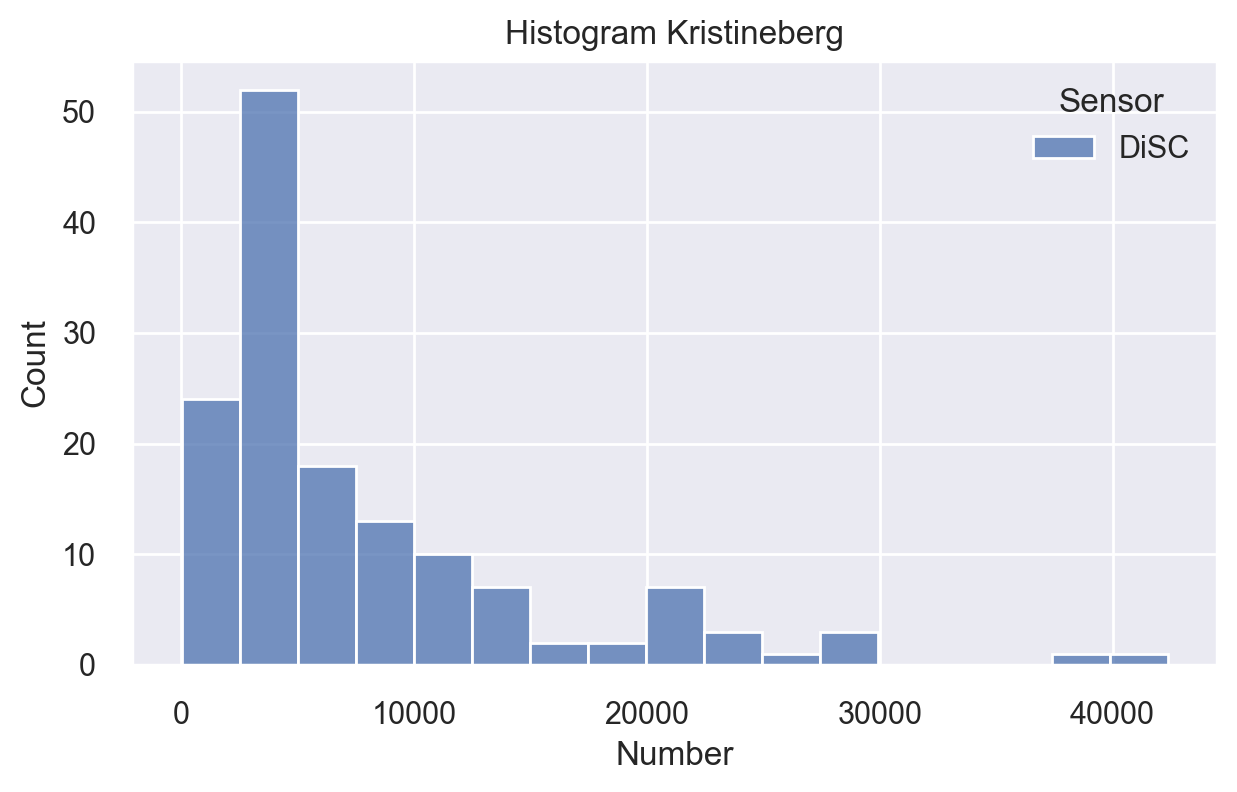

In [98]:
fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(focus_r_df.sort_values(by=['Sensor']), x=param, hue='Sensor', multiple='stack')
plt.title('Histogram Kristineberg')

plt.savefig(f'{fig_folder}/KristinebergHistogram1Sensor({param}).pdf')

plt.show()

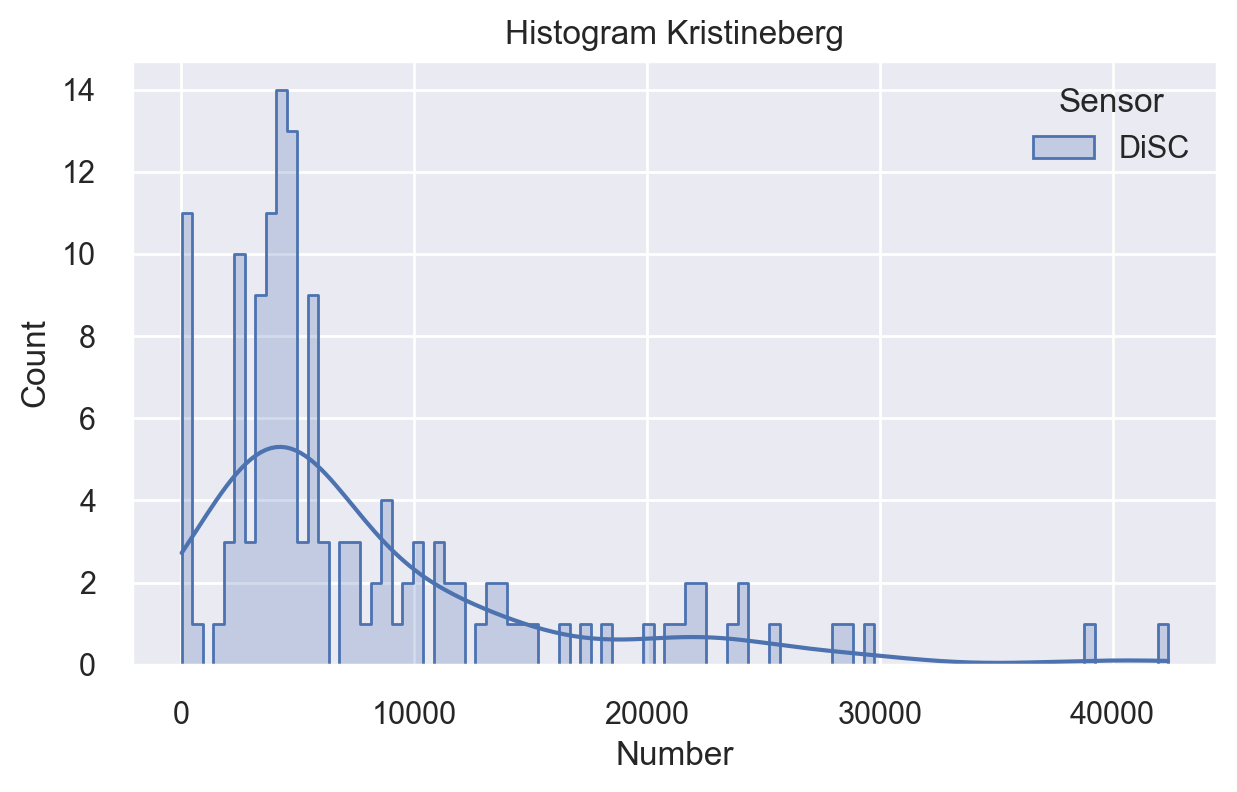

In [99]:
fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(focus_r_df.sort_values(by=['Sensor']), x=param, hue='Sensor', kde=True, element='step', bins=94)
plt.title('Histogram Kristineberg')

plt.savefig(f'{fig_folder}/KristinebergDistribution2Sensor({param}).pdf')

plt.show()

## Focus on Hötorget

In [100]:
focus_s_df = s_df.loc[s_df.Station == 'Hötorget'].sort_values(by=['Timestamp'])
focus_r_df = r_df.loc[r_df.Station == 'Hötorget'].sort_values(by=['Sensor'])

### Box plots sensors

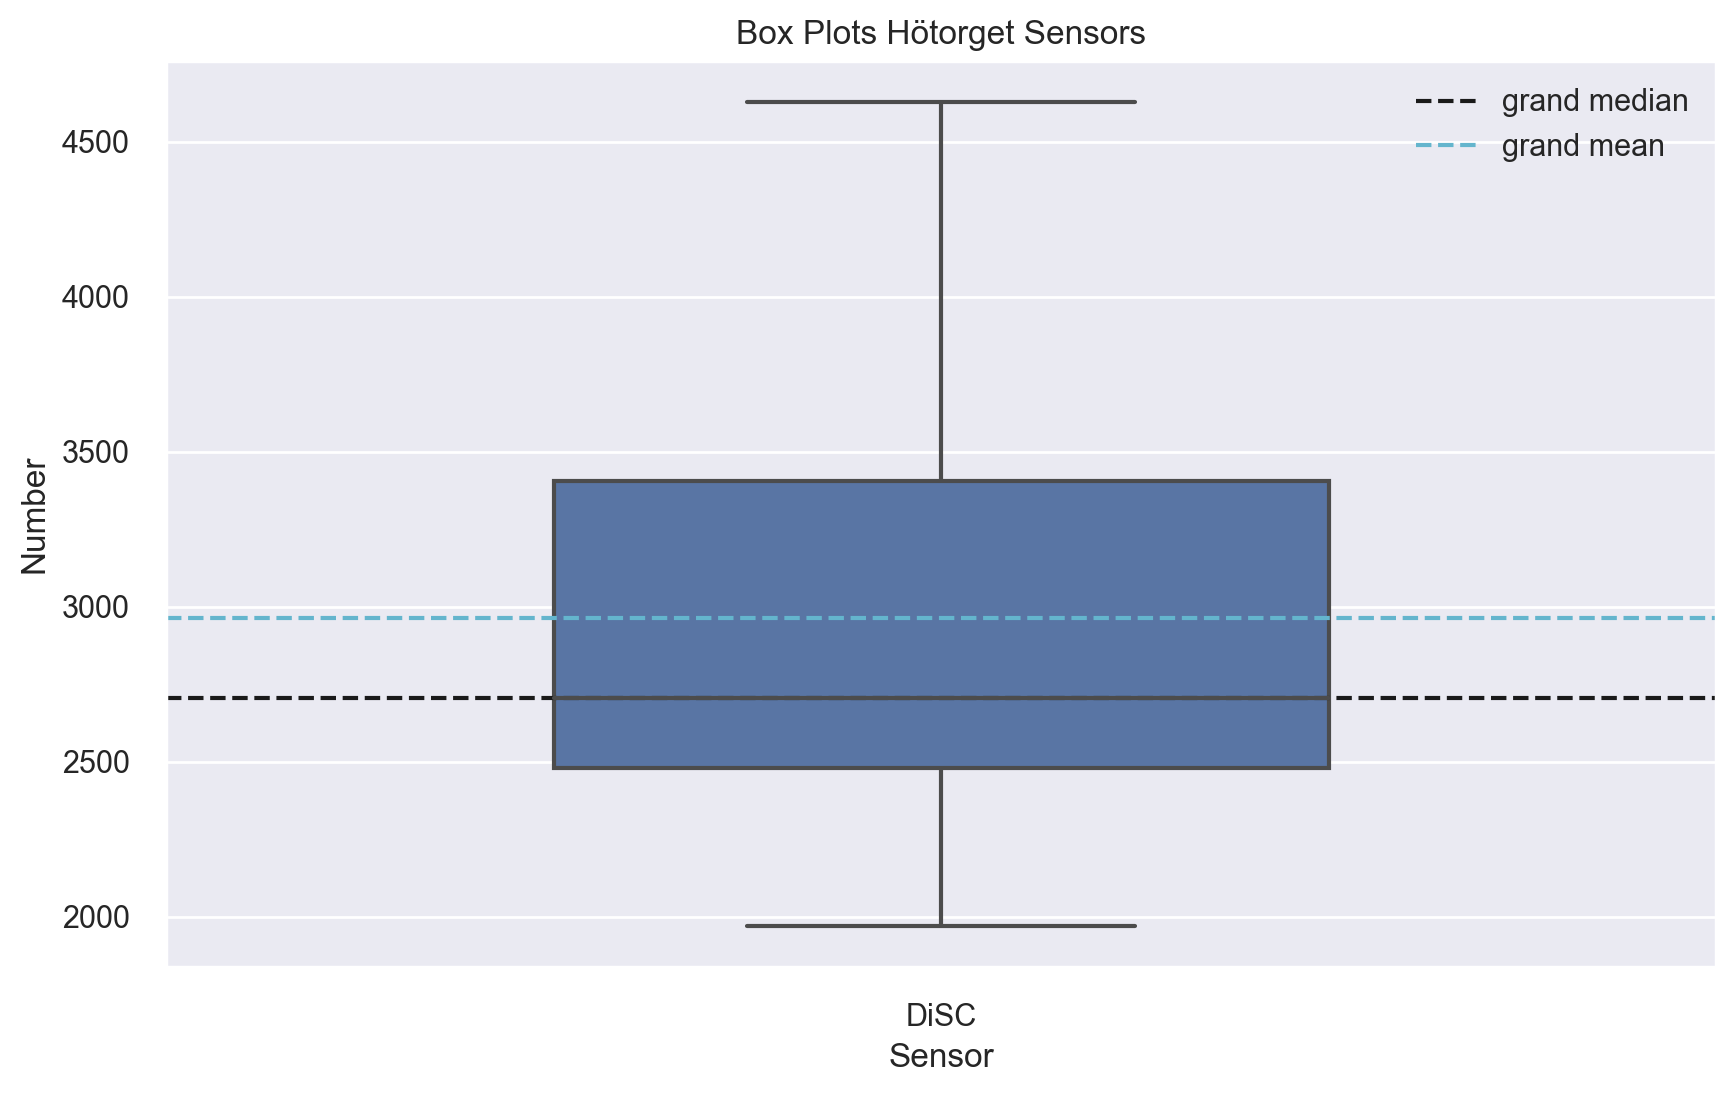

In [101]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Sensor', y=param, data=focus_r_df, width=0.5)

plt.axhline(focus_r_df[param].median(), c='k', linestyle='--', label='grand median')
plt.axhline(focus_r_df[param].mean(), c='c', linestyle='--', label='grand mean')

plt.legend()
plt.title('Box Plots Hötorget Sensors')
plt.savefig(f'{fig_folder}/Hötorget_box_plot_sensor({param}).pdf')
plt.show()

In [102]:
station_diffs['Hötorget']

[173.87355056607305,
 492.8839845462847,
 196.68660108817542,
 81.95875850229855,
 338.2310130396357,
 123.86637607066382,
 167.56334978292892,
 166.53592491025557,
 195.98299245937983,
 360.6875379050405,
 212.952886381429,
 174.31939077452054]

In [103]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
quantiles = focus_r_df.groupby('Sensor').agg(
    {param: 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

# Display stats
quantiles

Number                                                    \
            Q1    Q2      Q3  IQR lowerLimit upperLimit outliers   
Sensor                                                             
DiSC    2479.5  2704  3404.5  925       1092       4792        0   

                             
       prcnt_outliers count  
Sensor                       
DiSC                0   135

### Box plot sessions

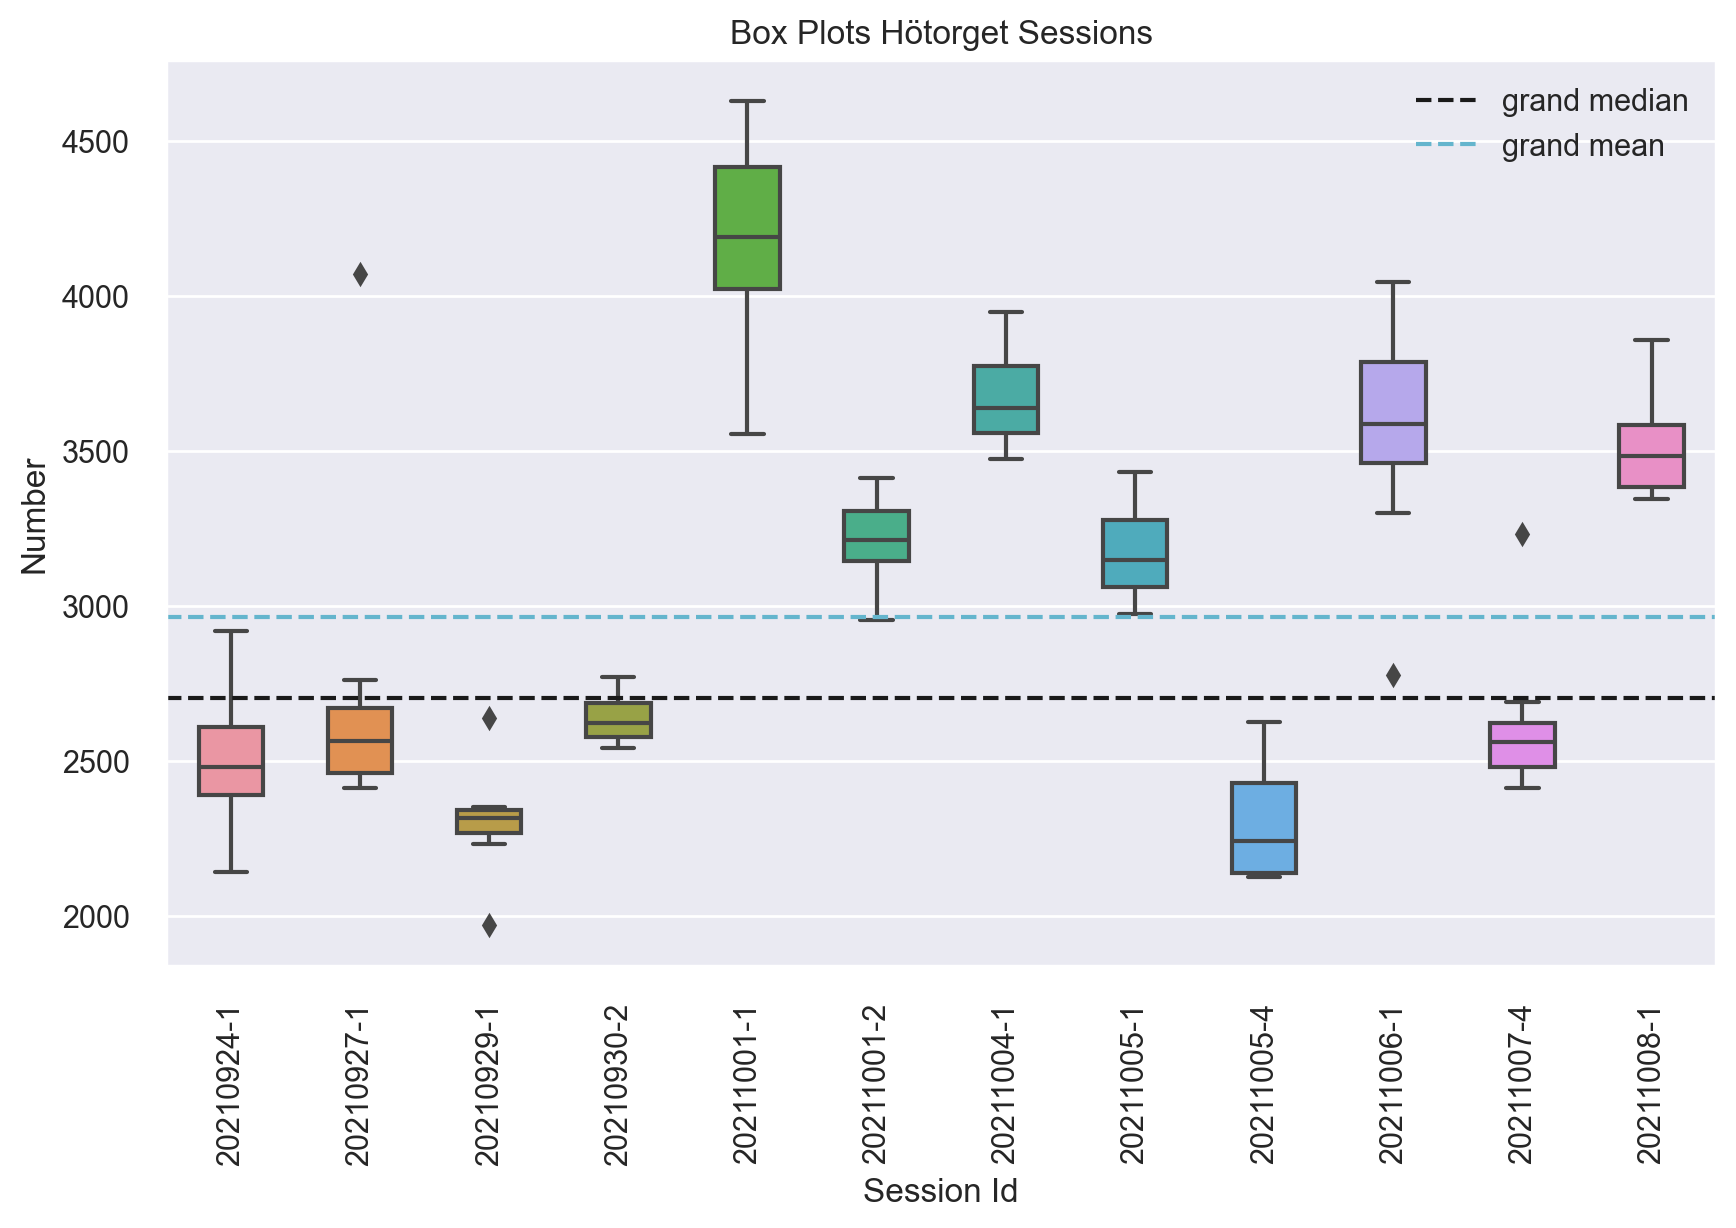

In [104]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Session Id', y=param, data=focus_r_df.sort_values(by=['Timestamp']), width=0.5)

plt.axhline(focus_r_df[param].median(), c='k', linestyle='--', label='grand median')
plt.axhline(focus_r_df[param].mean(), c='c', linestyle='--', label='grand mean')

plt.xticks(rotation=90)
plt.legend()
plt.title('Box Plots Hötorget Sessions')
plt.savefig(f'{fig_folder}/Hötorget_box_plot_sessions({param}).pdf')
plt.show()

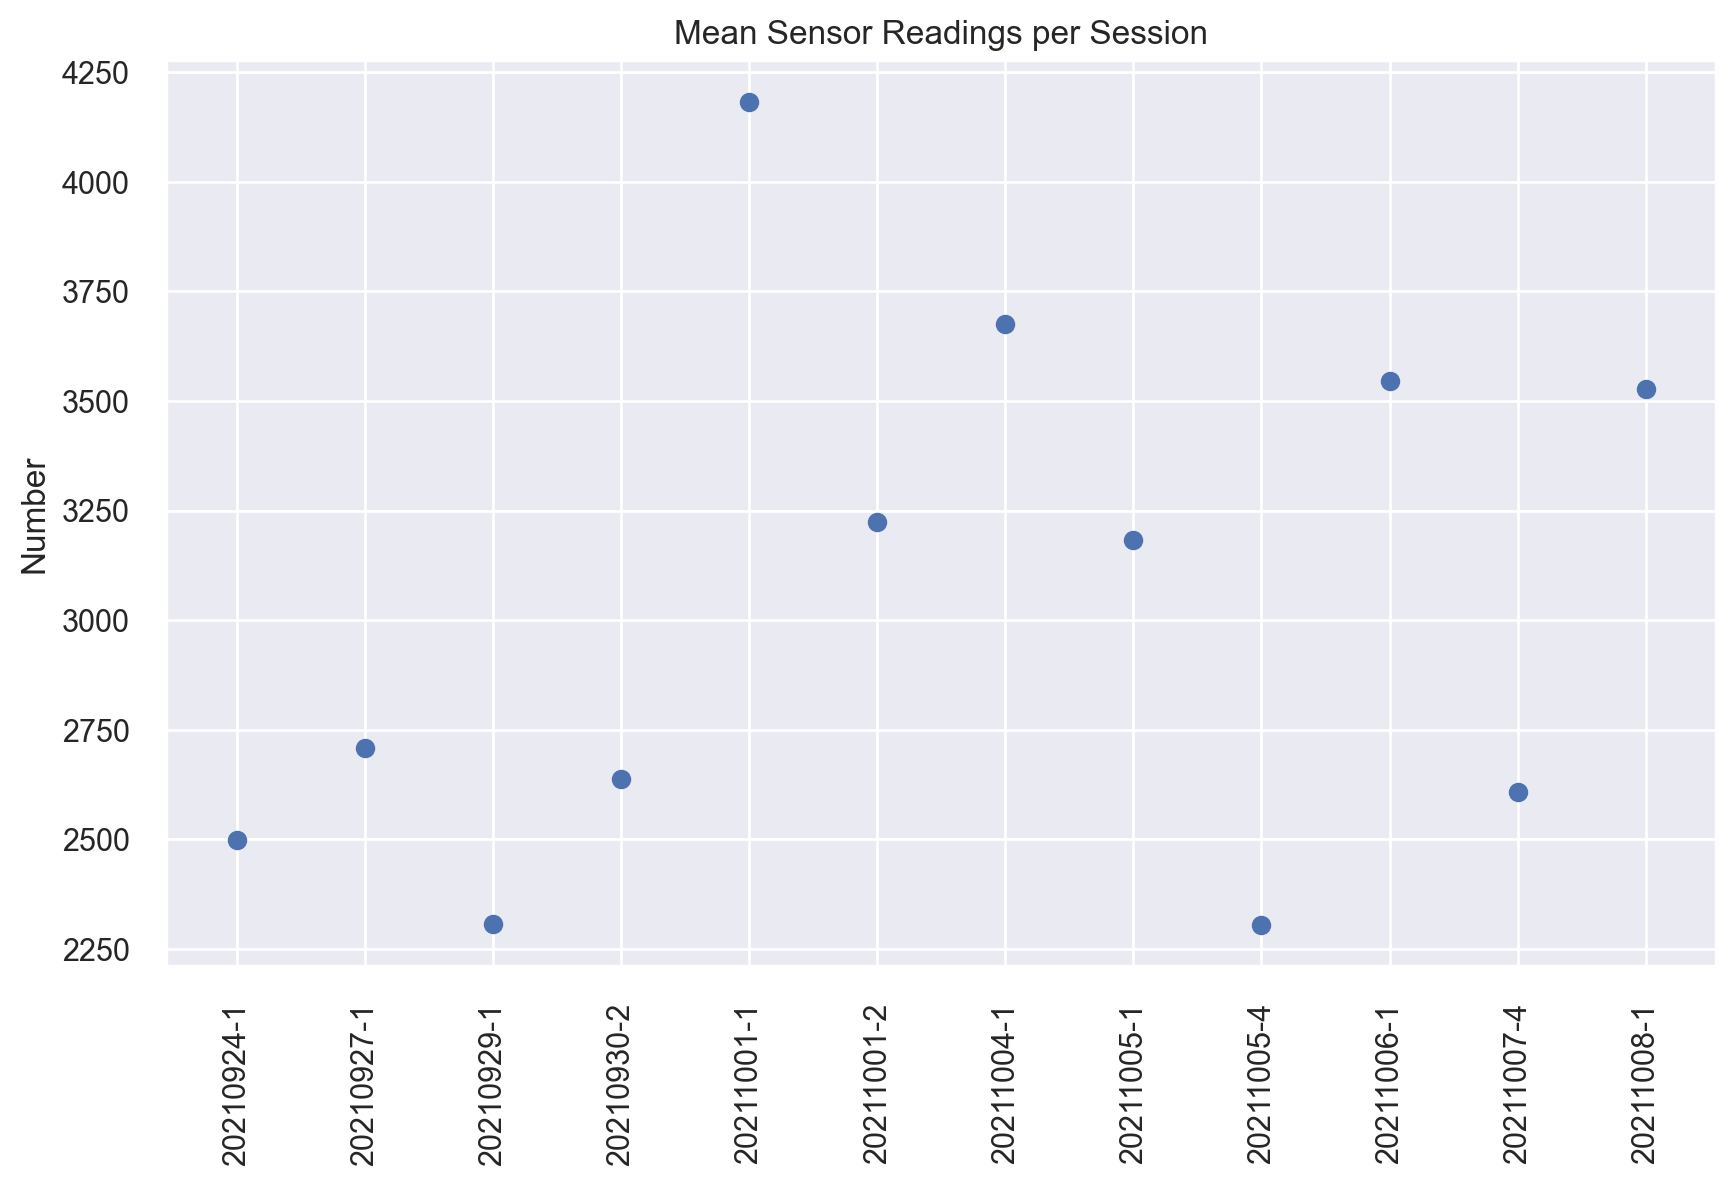

In [105]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

session_sensors = {}
for sensor, grp in focus_r_df.groupby('Sensor'):
    if sensor not in session_sensors:
        session_sensors[sensor] = {}
        
    for session_id, session_grp in grp.groupby('Session Id'):
        session_sensors[sensor][session_id] = session_grp[param].mean()
        
for sensor, data in session_sensors.items():
    ax.scatter(data.keys(), data.values(), label=sensor)
    
plt.xticks(rotation=90)
#plt.legend()
plt.title('Mean Sensor Readings per Session')
plt.savefig(f'{fig_folder}/Hötorget_mean_sensor_reading_per_session({param}).pdf')
plt.ylabel(param)

plt.show()

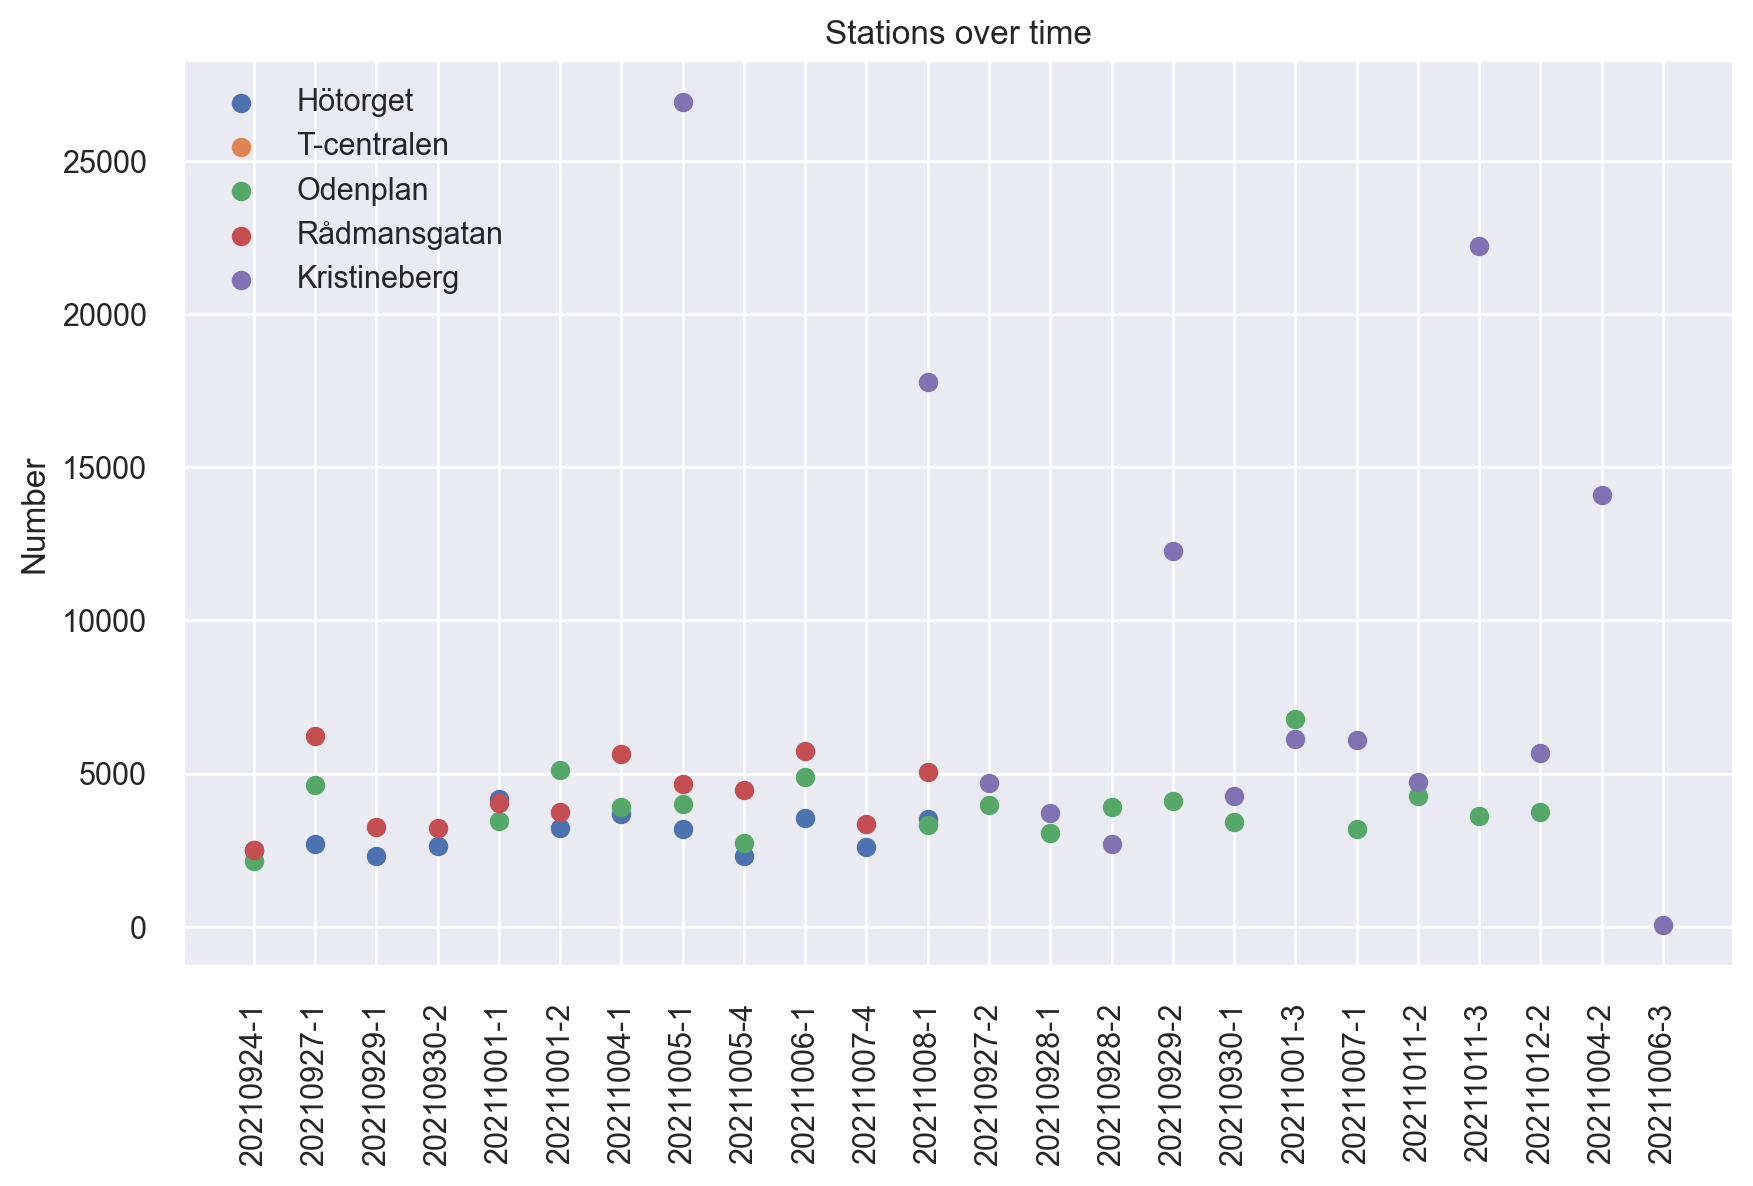

In [106]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

for station in ['Hötorget', 'T-centralen', 'Odenplan', 'Rådmansgatan', 'Kristineberg']:
    session_means = {}
    for session, grp in r_df[r_df['Station'] == station].groupby('Session Id'):
        session_means[session] = grp[param].mean()

    ax.scatter(session_means.keys(), session_means.values(), label=station)
    
plt.xticks(rotation=90)
plt.legend()
#plt.legend()
plt.title('Stations over time')
plt.savefig(f'{fig_folder}/focus_dfs_over_time({param}).pdf')
plt.ylabel(param)

plt.show()

### Distribution

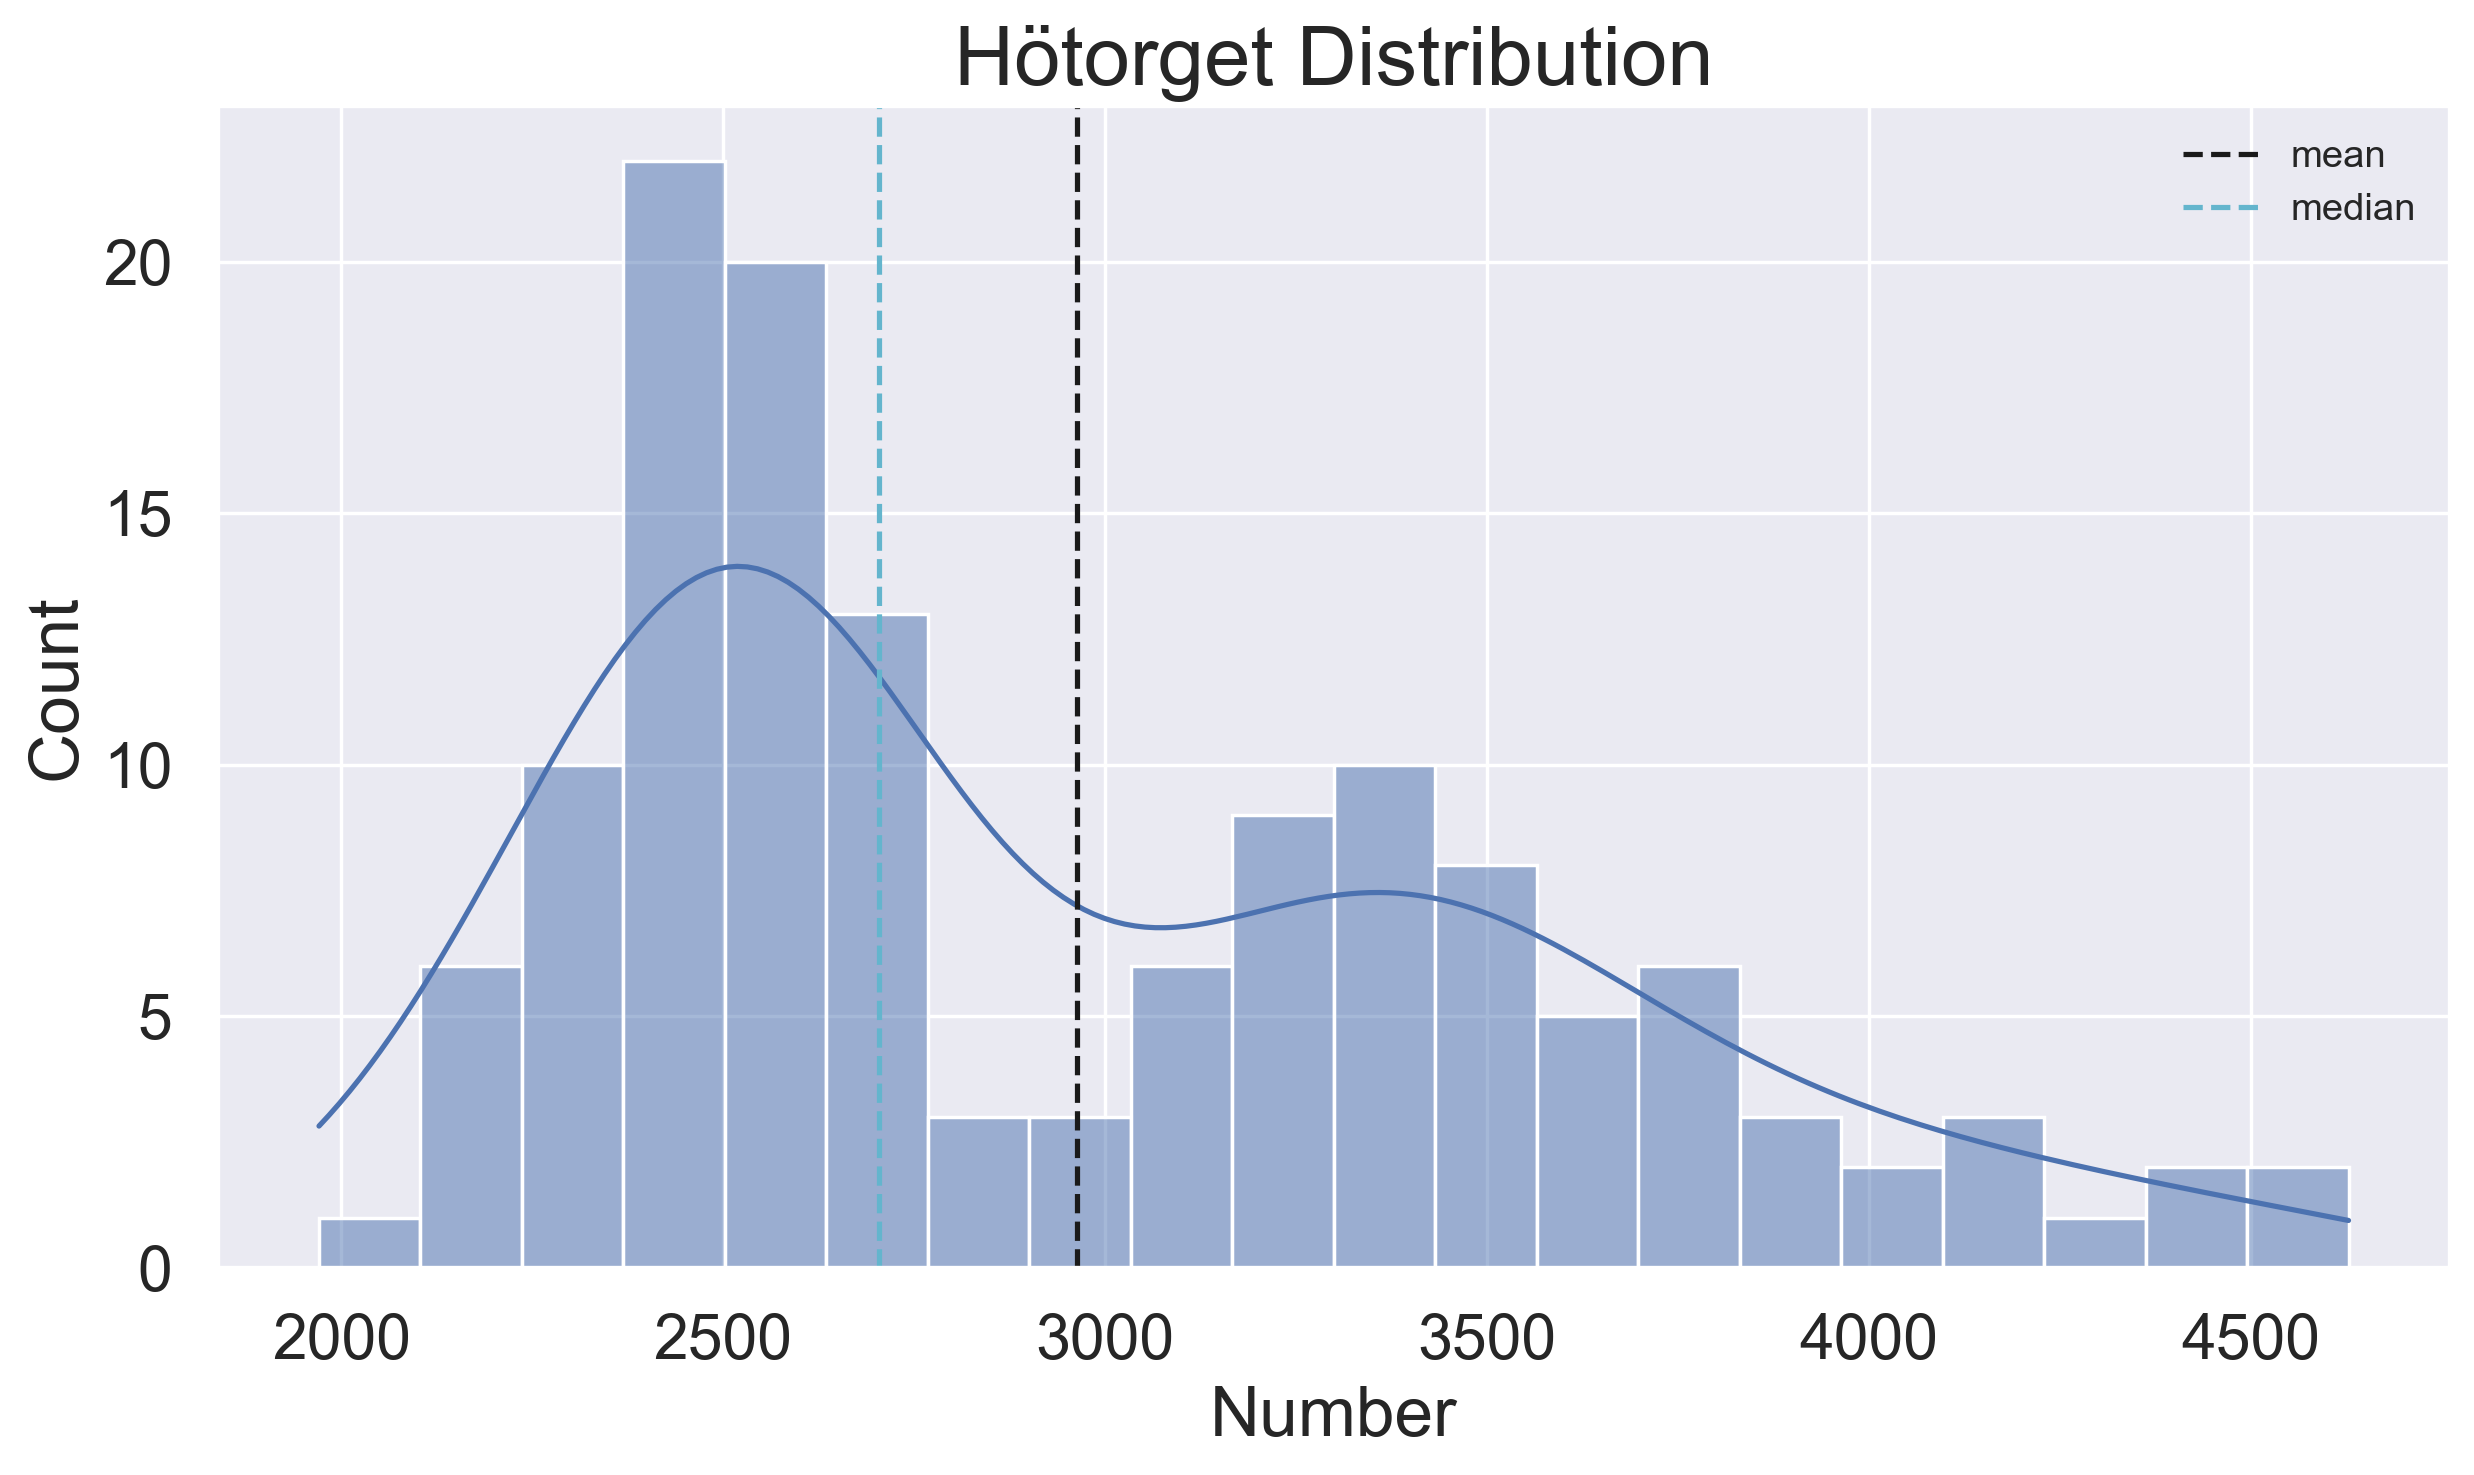

In [107]:
fig, ax = plt.subplots(dpi=250, figsize=[10, 6])

mean = focus_r_df[param].mean()
median = focus_r_df[param].median()
std = sample_std(focus_r_df[param].values)
s_skew = stats.skew(focus_r_df[param], bias=False)
s_kurt = stats.kurtosis(focus_r_df[param], bias=False)

sns.histplot(focus_r_df, x=param, kde=True, bins=20)

ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)

ax.set_xlabel(param, fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.set_title(f"Hötorget Distribution", fontsize=24)

ax.axvline(mean, c="k", linestyle="--", label="mean")
ax.axvline(median, c="c", linestyle="--", label="median")
ax.legend()
plt.tight_layout()

plt.savefig(f'{fig_folder}/HötorgetDistribution({param}).pdf')

plt.show()

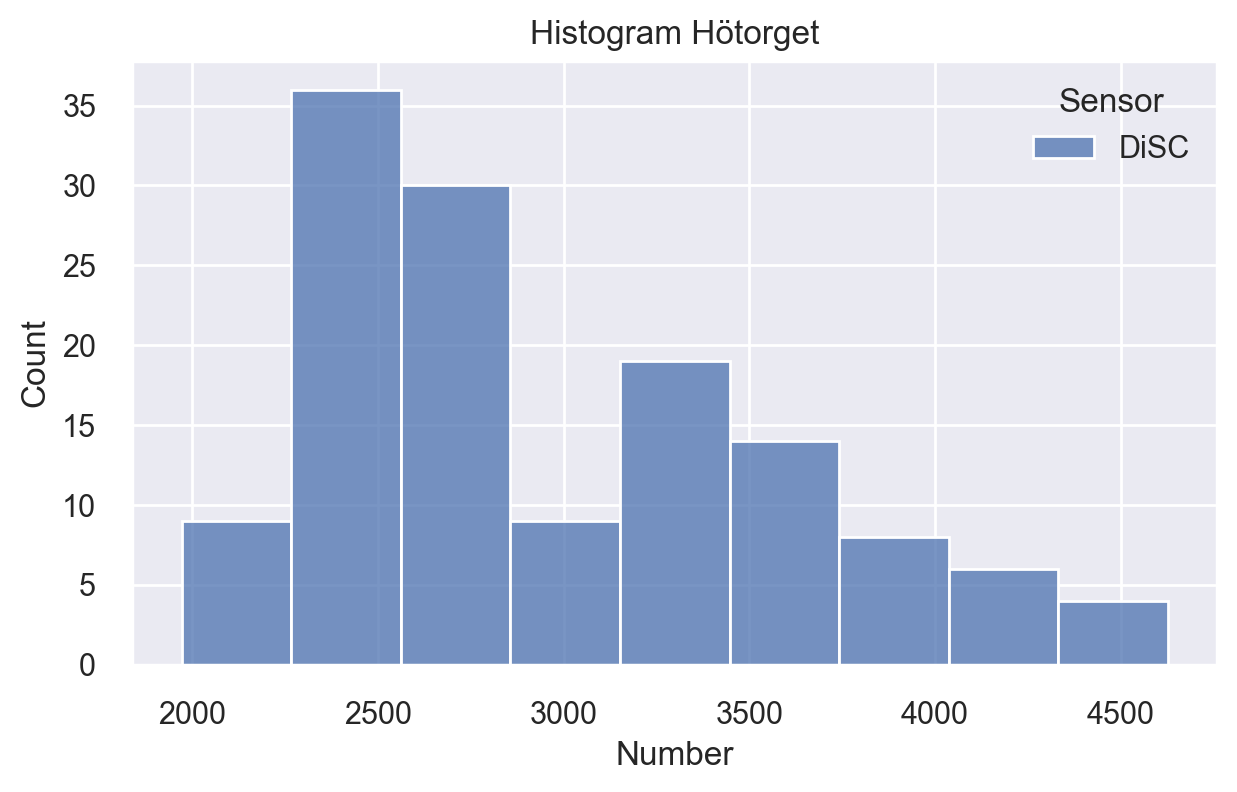

In [108]:
fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(focus_r_df.sort_values(by=['Sensor']), x=param, hue='Sensor', multiple='stack')
plt.title('Histogram Hötorget')

plt.savefig(f'{fig_folder}/HötorgetHistogram1Sensor({param}).pdf')

plt.show()

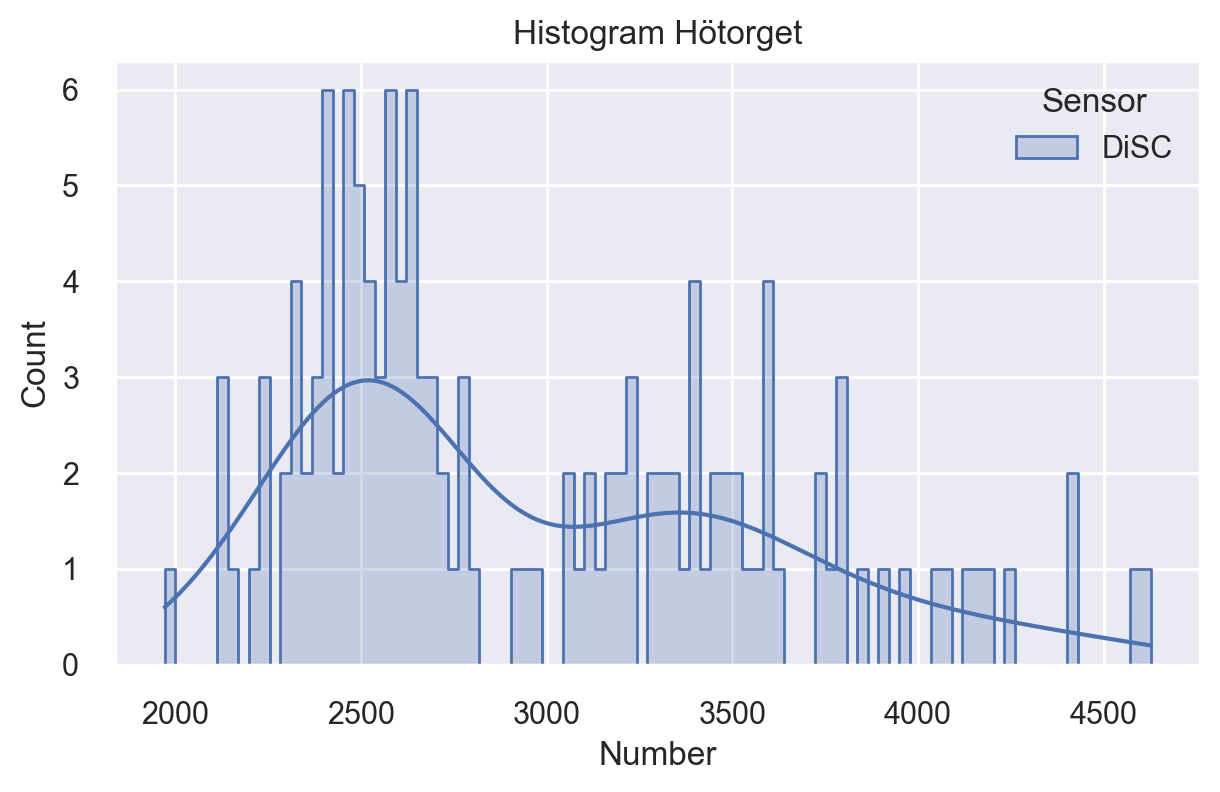

In [109]:
fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(focus_r_df.sort_values(by=['Sensor']), x=param, hue='Sensor', kde=True, element='step', bins=94)
plt.title('Histogram Hötorget')

plt.savefig(f'{fig_folder}/HötorgetDistribution2Sensor({param}).pdf')

plt.show()